In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import Random Forest 
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [3]:
from sklearn import preprocessing 

In [4]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [5]:
def calculate_metrics(confusion_matrix):
    num_classes = len(confusion_matrix)
    
    tp = np.diag(confusion_matrix)
    fp = np.sum(confusion_matrix, axis=0) - tp
    fn = np.sum(confusion_matrix, axis=1) - tp
    tn = np.sum(confusion_matrix) - (tp + fp + fn)
    
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)    #also known as sensitivity or true positive rate
    specificity = tn/(tn+fp)
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    f1 = (2*precision*recall)/(precision+recall)
    false_positive_rate = fp/(fp+tn)

    precision_total = 0
    for i in range(precision.size):
        precision_total += precision[i]
    average_precision = precision_total/(precision.size)

    recall_total = 0
    for i in range(recall.size):
        recall_total += recall[i]
    average_recall = recall_total/(recall.size)

    accuracy_total = 0
    for i in range(accuracy.size):
        accuracy_total += accuracy[i]
    average_accuracy = accuracy_total/(accuracy.size)
  
    f1_total = 0
    for i in range(f1.size):
        f1_total += f1[i]
    average_f1 = f1_total/(f1.size)

    df = pd.DataFrame({"precision":[precision[i] for i in range(precision.size)], \
                       "recall":[recall[i] for i in range(recall.size)], \
                       "accuracy":[accuracy[i] for i in range(accuracy.size)], \
                       "f1":[f1[i] for i in range(f1.size)]
                      }, index=['Away','Draw','Home'])
    
    df_2 = pd.DataFrame({"precision":[average_precision], \
                       "recall":[average_recall], \
                       "accuracy":[average_accuracy], \
                       "f1":[average_f1]  
                      }, index=['model average overall'])

    return tp, fp, fn, tn, df, df_2

In [6]:
teams_df = pd.read_csv("teams.csv")
results_df = pd.read_csv("results.csv")
fixtures_df = pd.read_csv("fixtures.csv")
players_df = pd.read_csv("players.csv")
startingXI_df = pd.read_csv("startingXI.csv")
odds_df = pd.read_csv("odds.csv")

- #### Aim analyse the results of the first season and make predictions for the second season

# EDA

## Let's look at teams

In [7]:
teams_df 

,TeamName,TeamID
0,Arlington,1
1,Anaheim,2
2,Atlanta,3
3,Baltimore,4
4,Boston,5
5,Chicago B,6
6,Chicago H,7
7,Cincinnati,8
8,Cleveland Queens,9
9,Denver,10


In [8]:
teams_dict = pd.Series(teams_df.TeamName.values,index=teams_df.TeamID).to_dict()

In [9]:
teams_dict

{1: 'Arlington',
 2: 'Anaheim',
 3: 'Atlanta',
 4: 'Baltimore',
 5: 'Boston',
 6: 'Chicago B',
 7: 'Chicago H',
 8: 'Cincinnati',
 9: 'Cleveland Queens',
 10: 'Denver',
 11: 'Detroit',
 12: 'Houston',
 13: 'Kansas City',
 14: 'Los Angeles',
 15: 'Miami',
 16: 'Milwaukee',
 17: 'Minneapolis',
 18: 'Montreal',
 19: 'New York S',
 20: 'New York C',
 21: 'Oakland',
 22: 'Philadelphia',
 23: 'Pittsburgh',
 24: 'St. Louis',
 25: 'San Diego',
 26: 'San Francisco',
 27: 'Seattle',
 28: 'Toronto'}

## Let's look at results

In [10]:
# load the results table
results_df

,SeasonID,Gameweek,MatchID,HomeTeamID,HomeScore,HomeShots,AwayTeamID,AwayScore,AwayShots
0,1,1,1,7,1,17,1,1,12
1,1,1,2,6,1,8,8,3,17
2,1,1,3,5,5,21,9,1,7
3,1,1,4,4,2,25,10,0,8
4,1,1,5,3,3,13,11,3,19
...,...,...,...,...,...,...,...,...,...
1507,2,54,1508,10,0,10,19,6,19
1508,2,54,1509,11,5,22,18,2,13
1509,2,54,1510,12,3,13,17,3,17
1510,2,54,1511,13,5,29,16,1,9


In [11]:
# check for NaN's
results_df.isna().values.any()

False

In [12]:
# how many results are there from season 1
len(results_df[results_df['SeasonID'] == 1])

756

In [13]:
# how many results are there from season 2
len(results_df[results_df['SeasonID'] == 2])

756

In [14]:
# generate a 'Results' column which compares the 'HomeScore' and 'AwayScore' columns and states the outcome: 'Home', 'Away' or 'Draw'  
results_df['Results'] = results_df.apply(lambda x: 'Home' if x['HomeScore'] >
                     x['AwayScore'] else ('Away' if x['HomeScore'] <
                     x['AwayScore'] else 'Draw'), axis=1)

In [15]:
results_df

,SeasonID,Gameweek,MatchID,HomeTeamID,HomeScore,HomeShots,AwayTeamID,AwayScore,AwayShots,Results
0,1,1,1,7,1,17,1,1,12,Draw
1,1,1,2,6,1,8,8,3,17,Away
2,1,1,3,5,5,21,9,1,7,Home
3,1,1,4,4,2,25,10,0,8,Home
4,1,1,5,3,3,13,11,3,19,Draw
...,...,...,...,...,...,...,...,...,...,...
1507,2,54,1508,10,0,10,19,6,19,Away
1508,2,54,1509,11,5,22,18,2,13,Home
1509,2,54,1510,12,3,13,17,3,17,Draw
1510,2,54,1511,13,5,29,16,1,9,Home


In [16]:
#number of Draw results in the results dataframe
print(f"number of Draws in the total results (season 1 and season 2) dataframe = {len(results_df[results_df['Results']=='Draw'])}")

number of Draws in the total results (season 1 and season 2) dataframe = 298


In [17]:
#number of Away wins in the results dataframe
print(f"number of Away wins in the total results (season 1 and season 2) dataframe = {len(results_df[results_df['Results']=='Away'])}")

number of Away wins in the total results (season 1 and season 2) dataframe = 508


In [18]:
#number of Home wins in the results dataframe
print(f"number of Home wins in the total results (season 1 and season 2) dataframe = {len(results_df[results_df['Results']=='Home'])}")

number of Home wins in the total results (season 1 and season 2) dataframe = 706


In [19]:
# create columns in results_df dataframe for the number of points scored by the Home team and Away team in each match: 3 points for a win and 1 point for a draw
results_df['Home_points'] = results_df.apply(lambda x: 1 if x['Results'] == 'Draw'
                                        else (3 if x['Results'] == 'Home'
                                              else 0), axis=1)

results_df['Away_points'] = results_df.apply(lambda x: 1 if x['Results'] == 'Draw'
                                        else (3 if x['Results'] == 'Away'
                                              else 0), axis=1)

In [20]:
results_df

,SeasonID,Gameweek,MatchID,HomeTeamID,HomeScore,HomeShots,AwayTeamID,AwayScore,AwayShots,Results,Home_points,Away_points
0,1,1,1,7,1,17,1,1,12,Draw,1,1
1,1,1,2,6,1,8,8,3,17,Away,0,3
2,1,1,3,5,5,21,9,1,7,Home,3,0
3,1,1,4,4,2,25,10,0,8,Home,3,0
4,1,1,5,3,3,13,11,3,19,Draw,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1507,2,54,1508,10,0,10,19,6,19,Away,0,3
1508,2,54,1509,11,5,22,18,2,13,Home,3,0
1509,2,54,1510,12,3,13,17,3,17,Draw,1,1
1510,2,54,1511,13,5,29,16,1,9,Home,3,0


### Which team won the league in the first season?

In [21]:
#extract the results from season 1
results_df_season_1 = results_df[results_df['SeasonID'] == 1].copy()
results_df_season_1

,SeasonID,Gameweek,MatchID,HomeTeamID,HomeScore,HomeShots,AwayTeamID,AwayScore,AwayShots,Results,Home_points,Away_points
0,1,1,1,7,1,17,1,1,12,Draw,1,1
1,1,1,2,6,1,8,8,3,17,Away,0,3
2,1,1,3,5,5,21,9,1,7,Home,3,0
3,1,1,4,4,2,25,10,0,8,Home,3,0
4,1,1,5,3,3,13,11,3,19,Draw,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
751,1,54,752,17,1,15,26,2,9,Away,0,3
752,1,54,753,18,2,12,25,0,9,Home,3,0
753,1,54,754,19,3,21,24,1,6,Home,3,0
754,1,54,755,20,0,8,23,2,6,Away,0,3


In [22]:
#As a check, extract all the rows where TeamID 15 played, either home or away. There should be 54 rows in total since each of the 28 teams play 27 games home and 27 games away 
#check_df = results_df_season_1[(results_df_season_1['HomeTeamID'] == 1) | (results_df_season_1['AwayTeamID'] == 1)].reset_index(drop=True)
#check_df

In [23]:
# group the 'results_df_season_1' dataframe by HomeTeamID and AwayTeamID and sum the Home_points and Away_points respectively 
season1_grouped_home = pd.DataFrame(results_df_season_1.groupby(['HomeTeamID'])['Home_points'].sum()).reset_index()
season1_grouped_away = pd.DataFrame(results_df_season_1.groupby(['AwayTeamID'])['Away_points'].sum()).reset_index()

In [24]:
# merge the two grouped dataframes on TeamID
season1_grouped = pd.merge(season1_grouped_home, season1_grouped_away, left_on='HomeTeamID', right_on='AwayTeamID')
season1_grouped

,HomeTeamID,Home_points,AwayTeamID,Away_points
0,1,41,1,36
1,2,20,2,12
2,3,21,3,35
3,4,60,4,57
4,5,54,5,52
5,6,56,6,49
6,7,50,7,45
7,8,75,8,50
8,9,24,9,28
9,10,25,10,10


In [25]:
season1_grouped = season1_grouped.drop(columns=['HomeTeamID']).rename(columns={'AwayTeamID':'TeamID'})
season1_grouped['total_points'] = season1_grouped['Home_points'] + season1_grouped['Away_points']
season1_grouped.drop(columns=['Home_points','Away_points'],inplace=True)

In [26]:
season1_grouped.sort_values('total_points',ascending=False)

,TeamID,total_points
14,15,138
7,8,125
3,4,117
18,19,113
4,5,106
26,27,105
5,6,105
20,21,96
6,7,95
23,24,94


In [27]:
# replace the TeamID
season1_grouped['TeamID'] = season1_grouped['TeamID'].replace(teams_dict)
season1_grouped.sort_values('total_points', ascending=False)

,TeamID,total_points
14,Miami,138
7,Cincinnati,125
3,Baltimore,117
18,New York S,113
4,Boston,106
26,Seattle,105
5,Chicago B,105
20,Oakland,96
6,Chicago H,95
23,St. Louis,94


- #### miami won season 1

### At what point in the season did that team secure their league title?

In [28]:
results_df_season_1_v2 = results_df_season_1.copy()

In [29]:
results_df_season_1_v2

,SeasonID,Gameweek,MatchID,HomeTeamID,HomeScore,HomeShots,AwayTeamID,AwayScore,AwayShots,Results,Home_points,Away_points
0,1,1,1,7,1,17,1,1,12,Draw,1,1
1,1,1,2,6,1,8,8,3,17,Away,0,3
2,1,1,3,5,5,21,9,1,7,Home,3,0
3,1,1,4,4,2,25,10,0,8,Home,3,0
4,1,1,5,3,3,13,11,3,19,Draw,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
751,1,54,752,17,1,15,26,2,9,Away,0,3
752,1,54,753,18,2,12,25,0,9,Home,3,0
753,1,54,754,19,3,21,24,1,6,Home,3,0
754,1,54,755,20,0,8,23,2,6,Away,0,3


In [30]:
def cumulative_points_function(df):
    results_df_season_1 = df
    # cumulative points dictionary
    team_points = {team: 0 for team in set(results_df_season_1['HomeTeamID']).union(set(results_df_season_1['AwayTeamID']))}
    #print(team_points)
    cumulative_points = []

    # Update cumulative points after each match
    for game_week in results_df_season_1['Gameweek'].unique():
        week_points = team_points.copy()
        matches = results_df_season_1[results_df_season_1['Gameweek'] == game_week]
        for _, match in matches.iterrows():
            week_points[match['HomeTeamID']] += match['Home_points']
            week_points[match['AwayTeamID']] += match['Away_points']
        #print(week_points)
        cumulative_points.append(week_points.copy())
        team_points = week_points

    # Add cumulative points to DataFrame
    results_df_season_1['cumulative_points'] = results_df_season_1['Gameweek'].apply(lambda x: cumulative_points[x-1])
    
    return results_df_season_1, cumulative_points

In [31]:
results_df_season_1_v2, cumulative_points = cumulative_points_function(results_df_season_1_v2)
results_df_season_1_v2

,SeasonID,Gameweek,MatchID,HomeTeamID,HomeScore,HomeShots,AwayTeamID,AwayScore,AwayShots,Results,Home_points,Away_points,cumulative_points
0,1,1,1,7,1,17,1,1,12,Draw,1,1,"{1: 1, 2: 3, 3: 1, 4: 3, 5: 3, 6: 0, 7: 1, 8: ..."
1,1,1,2,6,1,8,8,3,17,Away,0,3,"{1: 1, 2: 3, 3: 1, 4: 3, 5: 3, 6: 0, 7: 1, 8: ..."
2,1,1,3,5,5,21,9,1,7,Home,3,0,"{1: 1, 2: 3, 3: 1, 4: 3, 5: 3, 6: 0, 7: 1, 8: ..."
3,1,1,4,4,2,25,10,0,8,Home,3,0,"{1: 1, 2: 3, 3: 1, 4: 3, 5: 3, 6: 0, 7: 1, 8: ..."
4,1,1,5,3,3,13,11,3,19,Draw,1,1,"{1: 1, 2: 3, 3: 1, 4: 3, 5: 3, 6: 0, 7: 1, 8: ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,1,54,752,17,1,15,26,2,9,Away,0,3,"{1: 77, 2: 32, 3: 56, 4: 117, 5: 106, 6: 105, ..."
752,1,54,753,18,2,12,25,0,9,Home,3,0,"{1: 77, 2: 32, 3: 56, 4: 117, 5: 106, 6: 105, ..."
753,1,54,754,19,3,21,24,1,6,Home,3,0,"{1: 77, 2: 32, 3: 56, 4: 117, 5: 106, 6: 105, ..."
754,1,54,755,20,0,8,23,2,6,Away,0,3,"{1: 77, 2: 32, 3: 56, 4: 117, 5: 106, 6: 105, ..."


In [32]:
# Convert the cumulative points to a DataFrame for easier manipulation
points_df = pd.DataFrame(cumulative_points, index=results_df_season_1_v2['Gameweek'].unique())
points_df

,1,2,3,4,5,6,7,8,9,10,...,19,20,21,22,23,24,25,26,27,28
1,1,3,1,3,3,0,1,3,0,0,...,3,1,1,0,0,3,1,0,3,1
2,4,3,1,4,3,3,1,4,0,1,...,6,2,2,3,1,6,1,3,4,4
3,7,4,2,5,3,6,1,4,3,1,...,7,3,3,6,1,9,1,3,7,4
4,8,4,3,6,6,9,4,4,3,1,...,7,3,3,7,2,12,4,3,10,4
5,11,4,4,9,6,12,7,7,4,1,...,10,4,3,7,2,15,4,4,13,4
6,12,4,4,9,7,15,10,10,4,1,...,13,4,6,7,2,16,4,4,16,7
7,15,4,7,12,7,16,13,13,4,1,...,16,4,9,10,5,16,4,5,19,7
8,18,5,7,13,7,19,13,16,4,1,...,19,4,9,10,8,19,7,5,20,10
9,19,5,7,14,10,22,14,19,7,4,...,22,4,12,10,8,20,7,5,20,11
10,19,6,10,15,11,22,17,22,10,4,...,23,4,13,11,11,21,8,8,21,11


In [33]:
# Create a dataframe of the same no. of rows as there game weeks and where each row is the cumulative total number of points scored by each team
max_points_possible = points_df.iloc[::-1].cummax()[::-1]
#max_points_possible

In [34]:
# Determine the match week when the leading team secured the title
winning_team = points_df.iloc[-1].idxmax()                                                                             #get the column name of the team that won the league

for game_week in points_df.index:                                                                                      #loop through the game weeks from 0 to 54 in the index in cumulative points dataframe
    if points_df.loc[game_week, winning_team] > max_points_possible.drop(winning_team, axis=1).loc[game_week].max():   #find the week where the cumulative points for the team that won the league is greater
                                                                                                                       #than the highest points scored amongst all the remaining teams at the end of the season. 
        winning_week = game_week                                                                                       #That is the week where victory for the team that won the league was guaranteed.
        break

print(f"The winning team secured the league title on game week {winning_week}.")

The winning team secured the league title on game week 50.


### Another method of working out the week when the winning team secured the league title

In [35]:
def when_did_team_win(df):
    results_dict = {}
    cumulative_df = pd.DataFrame({'Gameweek':np.arange(df['Gameweek'].min(),df['Gameweek'].max()+1)})      #create a dataframe to contain the cumulative points won by each team
    for i in range(df['HomeTeamID'].min(),df['HomeTeamID'].max()+1):  #loop through the range of teams
        df_new = df[(df['HomeTeamID'] == i) | (df['AwayTeamID'] == i)].copy().reset_index(drop=True)   #extract the dataframes of matches, both home and away, where a particular team played
        
        df_new['Home_points_{0}'.format(i)] = 0
        df_new['Away_points_{0}'.format(i)] = 0

        df_new.loc[df_new['HomeTeamID'] == i, 'Home_points_{0}'.format(i)] = df_new['Home_points']
        df_new.loc[df_new['AwayTeamID'] == i, 'Away_points_{0}'.format(i)] = df_new['Away_points']
        
        df_new['total_points'] = df_new['Home_points_{0}'.format(i)] + df_new['Away_points_{0}'.format(i)]    #for each dataframe for a team create a column for summing together the points from home and away matches
        df_new['cumulative_points_team_{0}'.format(i)] = df_new['total_points'].cumsum()    #create a column for the cumulative sum of points
        cumulative_df[i] = df_new['cumulative_points_team_{0}'.format(i)]
        results_dict[i] = df_new#.drop(columns=['Home_points','Away_points'])
    return cumulative_df, results_dict

In [36]:
cumulative_df, results_dict = when_did_team_win(results_df_season_1)

In [37]:
# Vertically concatenate all the dataframes that are in the results_dict dictionary. When concatenated, each match will appear twice because in the same match points will be awarded to one 
# team or the other or both in event that the match is drawn
df_1 = pd.DataFrame()
for i in results_dict:
    df_1 = pd.concat([df_1,results_dict[i]],axis=0)[['SeasonID','Gameweek','MatchID','HomeTeamID','HomeScore','AwayTeamID','AwayScore','Results','Home_points','Away_points','total_points']]

In [38]:
df_1.sort_values('Gameweek',inplace=True)

In [39]:
df_1.reset_index(drop=True, inplace=True)
df_1

,SeasonID,Gameweek,MatchID,HomeTeamID,HomeScore,AwayTeamID,AwayScore,Results,Home_points,Away_points,total_points
0,1,1,1,7,1,1,1,Draw,1,1,1
1,1,1,9,26,0,15,2,Away,0,3,3
2,1,1,2,6,1,8,3,Away,0,3,3
3,1,1,6,2,2,12,1,Home,3,0,3
4,1,1,12,23,2,18,3,Away,0,3,3
...,...,...,...,...,...,...,...,...,...,...,...
1507,1,54,755,20,0,23,2,Away,0,3,3
1508,1,54,754,19,3,24,1,Home,3,0,0
1509,1,54,753,18,2,25,0,Home,3,0,0
1510,1,54,748,13,3,3,0,Home,3,0,3


In [40]:
# This function creates a column called 'TeamID' which matches to the 'total_points' column
def merged_teamID(df):
    index = []                                                                             #keep a record of all the teams that drew, so that when populating the TeamID column, both draw teams 
                                                                                           #are registered in separate rows
    df['TeamID'] = 0
    for k,l in df.iterrows():                                                              #loop through the dataframe 
        teams = []                                                                         #this list will be filled with teams that drew and then this list will be appended to the 'index' list
        if l['Results'] == 'Home' and l['total_points'] == 3:
            df.iloc[k, df.columns.get_loc('TeamID')] = l['HomeTeamID']
        elif l['Results'] == 'Home' and l['total_points'] == 0:
            df.iloc[k, df.columns.get_loc('TeamID')] = l['AwayTeamID']
        elif l['Results'] == 'Away' and l['total_points'] == 3:
            df.iloc[k, df.columns.get_loc('TeamID')] = l['AwayTeamID']
        elif l['Results'] == 'Away' and l['total_points'] == 0:
            df.iloc[k, df.columns.get_loc('TeamID')] = l['HomeTeamID']
        elif l['Results'] == 'Draw' and [l['HomeTeamID'], l['AwayTeamID']] not in index:
            teams.append(l['HomeTeamID'])
            teams.append(l['AwayTeamID'])
            index.append(teams)
            df.iloc[k, df.columns.get_loc('TeamID')] = l['HomeTeamID']
        elif l['Results'] == 'Draw' and [l['HomeTeamID'], l['AwayTeamID']] in index:
            df.iloc[k, df.columns.get_loc('TeamID')] = l['AwayTeamID']
    return df

In [41]:
df_1 = merged_teamID(df_1)

In [42]:
# from the concatenated dataframe, df_1, extract the rows where the HomeTeamID is 1 and the AwayTeamID is 15. There should be two entries i.e. one entry from the dataframe for TeamID 15 and 
# another from the dataframe for TeamID 1. In both cases the 'total_points' column is populated with points for the team that gained points and to whose dataframe the entry belongs to.
df_1[((df_1['HomeTeamID'] == 1) & (df_1['AwayTeamID'] == 15))]

,SeasonID,Gameweek,MatchID,HomeTeamID,HomeScore,AwayTeamID,AwayScore,Results,Home_points,Away_points,total_points,TeamID
929,1,34,463,1,0,15,2,Away,0,3,0,1
949,1,34,463,1,0,15,2,Away,0,3,3,15


In [43]:
df_1[df_1['Gameweek'] == 1].sort_values(['HomeTeamID'])

,SeasonID,Gameweek,MatchID,HomeTeamID,HomeScore,AwayTeamID,AwayScore,Results,Home_points,Away_points,total_points,TeamID
3,1,1,6,2,2,12,1,Home,3,0,3,2
10,1,1,6,2,2,12,1,Home,3,0,0,12
5,1,1,5,3,3,11,3,Draw,1,1,1,3
8,1,1,5,3,3,11,3,Draw,1,1,1,11
24,1,1,4,4,2,10,0,Home,3,0,0,10
20,1,1,4,4,2,10,0,Home,3,0,3,4
23,1,1,3,5,5,9,1,Home,3,0,3,5
21,1,1,3,5,5,9,1,Home,3,0,0,9
2,1,1,2,6,1,8,3,Away,0,3,3,8
6,1,1,2,6,1,8,3,Away,0,3,0,6


In [44]:
df_1.isna().values.any()

False

In [45]:
df_1

,SeasonID,Gameweek,MatchID,HomeTeamID,HomeScore,AwayTeamID,AwayScore,Results,Home_points,Away_points,total_points,TeamID
0,1,1,1,7,1,1,1,Draw,1,1,1,7
1,1,1,9,26,0,15,2,Away,0,3,3,15
2,1,1,2,6,1,8,3,Away,0,3,3,8
3,1,1,6,2,2,12,1,Home,3,0,3,2
4,1,1,12,23,2,18,3,Away,0,3,3,18
...,...,...,...,...,...,...,...,...,...,...,...,...
1507,1,54,755,20,0,23,2,Away,0,3,3,23
1508,1,54,754,19,3,24,1,Home,3,0,0,24
1509,1,54,753,18,2,25,0,Home,3,0,0,25
1510,1,54,748,13,3,3,0,Home,3,0,3,13


In [46]:
df_1[df_1['Gameweek'] == 1].sort_values(['HomeTeamID'])

,SeasonID,Gameweek,MatchID,HomeTeamID,HomeScore,AwayTeamID,AwayScore,Results,Home_points,Away_points,total_points,TeamID
3,1,1,6,2,2,12,1,Home,3,0,3,2
10,1,1,6,2,2,12,1,Home,3,0,0,12
5,1,1,5,3,3,11,3,Draw,1,1,1,3
8,1,1,5,3,3,11,3,Draw,1,1,1,11
24,1,1,4,4,2,10,0,Home,3,0,0,10
20,1,1,4,4,2,10,0,Home,3,0,3,4
23,1,1,3,5,5,9,1,Home,3,0,3,5
21,1,1,3,5,5,9,1,Home,3,0,0,9
2,1,1,2,6,1,8,3,Away,0,3,3,8
6,1,1,2,6,1,8,3,Away,0,3,0,6


In [47]:
#Open the cumulative_df dataframe which is outputted from the when_did_team_win function
pd.set_option('display.max_columns',None)
cumulative_df = cumulative_df.rename(columns=teams_dict)
cumulative_df

,Gameweek,Arlington,Anaheim,Atlanta,Baltimore,Boston,Chicago B,Chicago H,Cincinnati,Cleveland Queens,Denver,Detroit,Houston,Kansas City,Los Angeles,Miami,Milwaukee,Minneapolis,Montreal,New York S,New York C,Oakland,Philadelphia,Pittsburgh,St. Louis,San Diego,San Francisco,Seattle,Toronto
0,1,1,3,1,3,3,0,1,3,0,0,1,0,1,0,3,1,0,3,3,1,1,0,0,3,1,0,3,1
1,2,4,3,1,4,3,3,1,4,0,1,2,0,1,0,6,1,3,6,6,2,2,3,1,6,1,3,4,4
2,3,7,4,2,5,3,6,1,4,3,1,2,3,4,0,9,4,3,9,7,3,3,6,1,9,1,3,7,4
3,4,8,4,3,6,6,9,4,4,3,1,2,3,5,3,12,7,6,12,7,3,3,7,2,12,4,3,10,4
4,5,11,4,4,9,6,12,7,7,4,1,5,4,6,3,15,8,7,12,10,4,3,7,2,15,4,4,13,4
5,6,12,4,4,9,7,15,10,10,4,1,8,7,7,6,18,8,10,12,13,4,6,7,2,16,4,4,16,7
6,7,15,4,7,12,7,16,13,13,4,1,8,10,7,9,21,8,10,12,16,4,9,10,5,16,4,5,19,7
7,8,18,5,7,13,7,19,13,16,4,1,11,10,10,10,24,9,10,13,19,4,9,10,8,19,7,5,20,10
8,9,19,5,7,14,10,22,14,19,7,4,12,13,13,10,27,9,10,16,22,4,12,10,8,20,7,5,20,11
9,10,19,6,10,15,11,22,17,22,10,4,12,13,16,11,28,9,11,19,23,4,13,11,11,21,8,8,21,11


In [48]:
# Determine the match week when the leading team secured the title
winning_team = cumulative_df.iloc[-1].idxmax()                                                                             #get the column name of the team that won the league
winning_team

'Miami'

In [49]:
# reverse the key-value pairs in teams_dict
teams_dict_reversed = {}
value = []
key = []
for i in teams_dict:
    value.append(i)
    key.append(teams_dict[i])
    
for j in range(len(key)):
    teams_dict_reversed[key[j]] = value[j]

In [50]:
#max_points_possible.drop(teams_dict_reversed[winning_team], axis=1)

In [51]:
for game_week in cumulative_df.iloc[:,0]:                                                                                                         #loop through the game weeks from 0 to 54 in the index in cumulative points dataframe
    if cumulative_df.loc[game_week-1, winning_team] > max_points_possible.drop(teams_dict_reversed[winning_team], axis=1).loc[game_week].max():   #find the week where the cumulative points for the team that won the league is greater
                                                                                                                                                  #than the highest points scored amongst all the remaining teams at the end of the season.
        print(f"highest number of points scored by a team other than the winning team by the end of the season is {max_points_possible.drop(teams_dict_reversed[winning_team], axis=1).loc[game_week].max()}")    
        winning_week = game_week                                                                                                                  #That is the week where victory for the team that won the league was guaranteed.
        break

print(f"The winning team beat the above score, {max_points_possible.drop(teams_dict_reversed[winning_team], axis=1).loc[game_week].max()}, and secured the league title on game week {winning_week}.")

highest number of points scored by a team other than the winning team by the end of the season is 125
The winning team beat the above score, 125, and secured the league title on game week 50.


- #### Miami won the league title in week 50

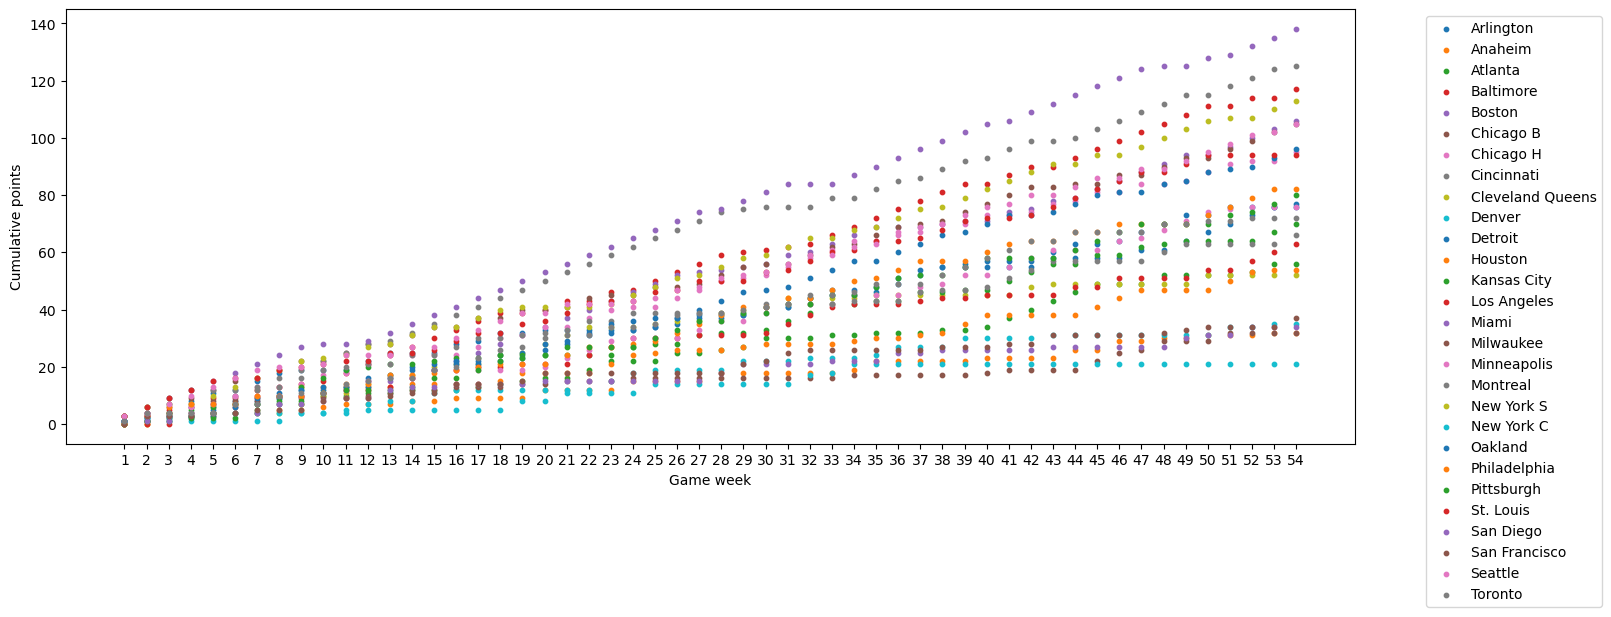

In [52]:
plt.figure(figsize=(16, 6))
for i in range(1,len(cumulative_df.columns)):
    plt.scatter(cumulative_df.iloc[:,0],cumulative_df.iloc[:,i], s=10, label=cumulative_df.columns[i])
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.xlabel('Game week')
plt.xticks(np.arange(min(cumulative_df.iloc[:,0]),max(cumulative_df.iloc[:,0])+1,1.0))
plt.ylabel('Cumulative points')
plt.show()

### Extract the results from season 2

In [53]:
#extract the results from season 2
results_df_season_2 = results_df[results_df['SeasonID'] == 2]
results_df_season_2

,SeasonID,Gameweek,MatchID,HomeTeamID,HomeScore,HomeShots,AwayTeamID,AwayScore,AwayShots,Results,Home_points,Away_points
756,2,1,757,2,1,14,1,2,16,Away,0,3
757,2,1,758,28,5,25,3,1,7,Home,3,0
758,2,1,759,27,0,7,4,1,15,Away,0,3
759,2,1,760,26,2,7,5,6,27,Away,0,3
760,2,1,761,25,0,6,6,3,17,Away,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
1507,2,54,1508,10,0,10,19,6,19,Away,0,3
1508,2,54,1509,11,5,22,18,2,13,Home,3,0
1509,2,54,1510,12,3,13,17,3,17,Draw,1,1
1510,2,54,1511,13,5,29,16,1,9,Home,3,0


In [54]:
#check which teams are present in the Home Team column
sorted(results_df['HomeTeamID'].unique())

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28]

In [55]:
#check which teams are present in the Away Team column
sorted(results_df['AwayTeamID'].unique())

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28]

## Let's look at fixtures

In [56]:
fixtures_df

,SeasonID,Gameweek,MatchID,HomeTeamID,AwayTeamID
0,2,1,757,2,1
1,2,1,758,28,3
2,2,1,759,27,4
3,2,1,760,26,5
4,2,1,761,25,6
...,...,...,...,...,...
751,2,54,1508,10,19
752,2,54,1509,11,18
753,2,54,1510,12,17
754,2,54,1511,13,16


In [57]:
# check for NaN's in the fixtures dataframe
fixtures_df.isna().values.any()

False

#### Check if the fixtures dataframe is identical to the results_df_season_2 dataframe

In [58]:
results_df_season_2_2 = results_df_season_2[['SeasonID','Gameweek','MatchID','HomeTeamID','AwayTeamID']].reset_index(drop=True)
results_df_season_2_2

,SeasonID,Gameweek,MatchID,HomeTeamID,AwayTeamID
0,2,1,757,2,1
1,2,1,758,28,3
2,2,1,759,27,4
3,2,1,760,26,5
4,2,1,761,25,6
...,...,...,...,...,...
751,2,54,1508,10,19
752,2,54,1509,11,18
753,2,54,1510,12,17
754,2,54,1511,13,16


In [59]:
fixtures_df.equals(results_df_season_2_2)

True

- #### the fixtures dataframe is identical to the results_df_season_2 dataframe containing only the following features: 'SeasonID','Gameweek','MatchID','HomeTeamID','AwayTeamID'

## Let's look at players

In [60]:
players_df

,PlayerName,TeamID,PositionID
0,Odell Williams,1,1
1,Anthony Jennings,1,1
2,Jeffrey Maxwell,1,1
3,Robert Compton,1,2
4,Jason Kearns,1,2
...,...,...,...
695,Edward Diaz,9,4
696,Terry Hill,9,4
697,Ricardo Williams,9,4
698,Hugh Thomson,9,4


In [61]:
players_df.dtypes

PlayerName    object
TeamID         int64
PositionID     int64
dtype: object

In [62]:
# get the unique TeamID's in the players dataframe
sorted(players_df['TeamID'].unique())

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28]

In [63]:
# get the unique PositionID's in the players dataframe
sorted(players_df['PositionID'].unique())

[1, 2, 3, 4]

In [64]:
# check for duplicate names of players
duplicated_players = players_df[players_df['PlayerName'].duplicated(keep=False)].copy()
duplicated_players

,PlayerName,TeamID,PositionID
10,Frank Smith,1,2
92,Frank Smith,12,3
244,Fred Williams,18,4
370,Robert Pitts,22,4
414,Fred Williams,24,3
650,Robert Pitts,8,1


In [65]:
# Change the name of the players with the same name to include the TeamID as well in the name in the player_df dataframe
conditions_1 = (players_df['TeamID'] == 1) & (players_df['PositionID'] == 2) &  (players_df['PlayerName'] == 'Frank Smith')
conditions_2 = (players_df['TeamID'] == 12) & (players_df['PositionID'] == 3) &  (players_df['PlayerName'] == 'Frank Smith')
conditions_3 = (players_df['TeamID'] == 18) & (players_df['PositionID'] == 4) &  (players_df['PlayerName'] == 'Fred Williams')
conditions_4 = (players_df['TeamID'] == 24) & (players_df['PositionID'] == 3) &  (players_df['PlayerName'] == 'Fred Williams')
conditions_5 = (players_df['TeamID'] == 22) & (players_df['PositionID'] == 4) &  (players_df['PlayerName'] == 'Robert Pitts')
conditions_6 = (players_df['TeamID'] == 8) & (players_df['PositionID'] == 1) &  (players_df['PlayerName'] == 'Robert Pitts')

players_df.loc[conditions_1, 'PlayerName'] = 'Frank Smith_1'
players_df.loc[conditions_2, 'PlayerName'] = 'Frank Smith_12'
players_df.loc[conditions_3, 'PlayerName'] = 'Fred Williams_18'
players_df.loc[conditions_4, 'PlayerName'] = 'Fred Williams_24'
players_df.loc[conditions_5, 'PlayerName'] = 'Robert Pitts_22'
players_df.loc[conditions_6, 'PlayerName'] = 'Robert Pitts_8'

In [66]:
# add another column in the table of duplicated players for the new names
duplicated_players['PlayerNameNew'] = np.nan
duplicated_players.loc[(duplicated_players['TeamID'] == 1) & (duplicated_players['PositionID'] == 2) &  (duplicated_players['PlayerName'] == 'Frank Smith'), 'PlayerNameNew'] = 'Frank Smith_1'
duplicated_players.loc[(duplicated_players['TeamID'] == 12) & (duplicated_players['PositionID'] == 3) &  (duplicated_players['PlayerName'] == 'Frank Smith'), 'PlayerNameNew'] = 'Frank Smith_12'
duplicated_players.loc[(duplicated_players['TeamID'] == 18) & (duplicated_players['PositionID'] == 4) &  (duplicated_players['PlayerName'] == 'Fred Williams'), 'PlayerNameNew'] = 'Fred Williams_18'
duplicated_players.loc[(duplicated_players['TeamID'] == 24) & (duplicated_players['PositionID'] == 3) &  (duplicated_players['PlayerName'] == 'Fred Williams'), 'PlayerNameNew'] = 'Fred Williams_24'
duplicated_players.loc[(duplicated_players['TeamID'] == 22) & (duplicated_players['PositionID'] == 4) &  (duplicated_players['PlayerName'] == 'Robert Pitts'), 'PlayerNameNew'] = 'Robert Pitts_22'
duplicated_players.loc[(duplicated_players['TeamID'] == 8) & (duplicated_players['PositionID'] == 1) &  (duplicated_players['PlayerName'] == 'Robert Pitts'), 'PlayerNameNew'] = 'Robert Pitts_8'

In [67]:
duplicated_players

,PlayerName,TeamID,PositionID,PlayerNameNew
10,Frank Smith,1,2,Frank Smith_1
92,Frank Smith,12,3,Frank Smith_12
244,Fred Williams,18,4,Fred Williams_18
370,Robert Pitts,22,4,Robert Pitts_22
414,Fred Williams,24,3,Fred Williams_24
650,Robert Pitts,8,1,Robert Pitts_8


In [68]:
players_df[players_df['TeamID'] == 1]

,PlayerName,TeamID,PositionID
0,Odell Williams,1,1
1,Anthony Jennings,1,1
2,Jeffrey Maxwell,1,1
3,Robert Compton,1,2
4,Jason Kearns,1,2
5,Scott Rosenberg,1,2
6,William Tseng,1,2
7,Antonio Carver,1,2
8,Jose McRay,1,2
9,Carl Sterling,1,2


In [69]:
# check again that the duplicate names of players has gone
players_df[players_df['PlayerName'].duplicated(keep=False)]

,PlayerName,TeamID,PositionID


In [70]:
#get the total number of players for each team
players_df.groupby(['TeamID']).count()

,PlayerName,PositionID
TeamID,,
1,25,25
2,25,25
3,25,25
4,25,25
5,25,25
6,25,25
7,25,25
8,25,25
9,25,25


In [71]:
players_df['PositionID']= players_df['PositionID'].astype(str)

In [72]:
#Group players_df by 'TeamID' and join up all the player names for each team
pd.set_option('display.max_rows',30)
pd.set_option('display.max_colwidth',None)
players_df_grouped = pd.DataFrame(players_df.groupby(['TeamID'])['PlayerName'].apply(lambda x: ','.join(pd.unique(x)))).reset_index()
players_df_grouped_2 = pd.DataFrame(players_df.groupby(['TeamID'])['PositionID'].apply(lambda x: ','.join(x))).reset_index()
players_df_grouped['Positions'] = players_df_grouped_2['PositionID']
players_df_grouped.rename(columns={'PlayerName':'Players'},inplace=True)
players_df_grouped

,TeamID,Players,Positions
0,1,"Odell Williams,Anthony Jennings,Jeffrey Maxwell,Robert Compton,Jason Kearns,Scott Rosenberg,William Tseng,Antonio Carver,Jose McRay,Carl Sterling,Frank Smith_1,Vincent Woodby,Milton Tyler,Robert Watson,Matthew Cabezas,Jerry Leduc,Darin Pipkin,Herb Escobar,Dan Fischer,Joseph Thompson,Mike Smith,David Hartman,Ralph Stine,Bruce Roberts,Raymond Davis","1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4"
1,2,"Brent Wiley,Wallace McNear,John Matlock,Steven Taylor,John Davis,Shawn Carr,John Miraglia,Michael Gallardo,Vincent Viera,Kirby Radford,Jim Thomas,David Ward,Gregory Case,Charles Pesce,Peter Salas,Charles Walters,David Ehrlich,Byron Riddick,George Adams,Darrell Crump,Robert Jefferies,Robert Fain,Terry Dangelo,Gary Levine,Vincent Gore","1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4"
2,3,"Maurice Troutman,Rick Fernandez,Thomas Baltes,Gabriel Barnett,Randall Wilson,Emil Hollins,Hilario Lentz,Robert Mendez,Thomas Bonner,David Bryer,Matthew Cook,Owen Roussel,Jonah Ruffin,Barry Wagner,Laverne Monaghan,Douglas Shepherd,Gary Hewitt,Thomas McGowan,Richard Luckett,Vincent Ray,Jon Geren,Kenneth Schaeffer,Kenneth Morado,Jay Hernandez,James Savage","1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4"
3,4,"Humberto Sherrard,Stanley May,Michael Smith,John Russell,Rodney Drake,James Alvarez,William Moulton,Robert Graves,Kevin Hershey,Ted Williams,Christopher Harrison,Andrew Berry,Aaron Hyatt,Earl White,Ray Brown,William Griffith,Frank McCullough,Chad Gillam,Charles Harris,Howard Maynard,Chris Blough,Howard Hurt,David Phillips,Paul Lawson,Billy Colon","1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4"
4,5,"Steven Moore,Seth Fray,Craig Littleton,Ronnie Jacob,Walker Wyatt,Eugene Whitacre,Ralph Porter,Jack Floyd,Jose Vega,Fred Burley,Ricky Yates,Charles Gordon,Joseph Goff,Donald Morgan,James Edwards,Thomas Do,Matthew Morgan,Don Oliver,Michael McDaniel,Jack Trusty,Robin Sellers,Robert Schaub,Eric Coyne,Earl Stone,Michael McNeil","1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4"
5,6,"Daniel Enriquez,Charlie Melton,Robert Basile,Luis Lewis,Cody Chipman,James Gillham,Richard Ewalt,Philip Maldonado,Donald Talley,Mike Bumpers,Edwin Brown,Gary Nichols,Michael Yang,Johnathon Bickham,Philip Maupin,Lucas Jones,Columbus Leblanc,Jason Urban,Richard Gutierrez,Gabriel Oliver,Charles Martin,Roberto Berry,Gary Owens,Jeffrey Bachelder,Scott Jones","1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4"
6,7,"Cleveland Hinrichs,Douglas King,Stephen Sallee,Harold Wilson,Clayton Davis,Julius Skinner,David Kopec,Greg Cooper,Gerald Nelson,Porter Harris,David Larson,Robert Shaffer,George Oakes,Jeff Contreras,Elmer Hancock,Michael Winters,Josh Fritz,Wendell Marcotte,Sammie Anderson,Gary Puente,Edgar Gunter,Johnny Parker,Glen Rhein,Sidney Bell,Tony Graham","1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4"
7,8,"Robert Pitts_8,Ronald Martinez,Michael Ardito,Robert Locklear,Daniel Phillips,Jerry Moeller,Kory Hatton,Jack Knapp,Glenn Gallegos,Henry Houle,Sonny Lydon,Vernon Bloomer,Dominique Webb,Harry Pope,Anthony Hartwell,Jesse Geer,Irwin Rideout,Robert Jameson,Ronald Stein,Ronald Benson,Archie Hartley,Gregory Splawn,Ronald Caudillo,Daniel Lee,Patrick Tillman","1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4"
8,9,"Patrick Jean,John Crouch,Ernest Carlson,Lewis Hawthorne,Terry Perkins,Glenn Stewart,Alfred Paradis,Craig Saleem,Brandon Bartlett,Toby McKinney,Steven Moeller,Charles Spillman,Matthew Harris,Michael Wheeler,Danny Sharp,John McIntyre,Robert Riccardi,Reynaldo Hawkins,Fletcher Yoder,Steven Patel,Edward Diaz,Terry Hill,Ricardo Williams,Hugh Thomson,Isidro Swanson","1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4"
9,10,"Lionel Miller,James Mullen,Frank Greene,Alfred Edwards,Adam Johnson,Michael Markham,Jacob Winchester,Joseph Bowman,Max Williams,John King,Floyd Pope,Henry Tevis,Jeffery Cost,William Morris,Dominic Moore,Amos Wilson,Weldon Pasley,Gregorio Davis,Earl Cook,John Jones,Cecil Myers,Anthony Lee,Erik Briggs,Elmer Barfield,Richa

In [73]:
# Check if there are differences in the total number of goalkeepers, midfielders, strikers and defenders in each team
players_df_grouped['Positions'].unique()

array(['1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4'], dtype=object)

In [74]:
# Create a dictionary of players to position from 'PlayerName' column and 'PositionID' column in players_df
players_position_dict = pd.Series(players_df.PositionID.values,index=players_df.PlayerName).to_dict()

In [75]:
# Create a dictionary of all the players in each of the 28 teams from the 'Players' column and 'TeamID' column in the players_df_grouped dataframe
players_team_dict = pd.Series(players_df_grouped.Players.values,index=players_df_grouped.TeamID).to_dict()

In [76]:
#players_position_dict

In [77]:
players_team_dict

{1: 'Odell Williams,Anthony Jennings,Jeffrey Maxwell,Robert Compton,Jason Kearns,Scott Rosenberg,William Tseng,Antonio Carver,Jose McRay,Carl Sterling,Frank Smith_1,Vincent Woodby,Milton Tyler,Robert Watson,Matthew Cabezas,Jerry Leduc,Darin Pipkin,Herb Escobar,Dan Fischer,Joseph Thompson,Mike Smith,David Hartman,Ralph Stine,Bruce Roberts,Raymond Davis',
 2: 'Brent Wiley,Wallace McNear,John Matlock,Steven Taylor,John Davis,Shawn Carr,John Miraglia,Michael Gallardo,Vincent Viera,Kirby Radford,Jim Thomas,David Ward,Gregory Case,Charles Pesce,Peter Salas,Charles Walters,David Ehrlich,Byron Riddick,George Adams,Darrell Crump,Robert Jefferies,Robert Fain,Terry Dangelo,Gary Levine,Vincent Gore',
 3: 'Maurice Troutman,Rick Fernandez,Thomas Baltes,Gabriel Barnett,Randall Wilson,Emil Hollins,Hilario Lentz,Robert Mendez,Thomas Bonner,David Bryer,Matthew Cook,Owen Roussel,Jonah Ruffin,Barry Wagner,Laverne Monaghan,Douglas Shepherd,Gary Hewitt,Thomas McGowan,Richard Luckett,Vincent Ray,Jon Geren,Ke

## Let's look at startingXI

In [78]:
startingXI_df

,MatchID,StartingXI
0,1,"Stephen Sallee,Porter Harris,David Larson,Julius Skinner,Gerald Nelson,Sammie Anderson,Josh Fritz,Michael Winters,Sidney Bell,Johnny Parker,Edgar Gunter"
1,1,"Anthony Jennings,Jose McRay,Antonio Carver,Scott Rosenberg,Robert Compton,Darin Pipkin,Matthew Cabezas,Herb Escobar,Raymond Davis,Joseph Thompson,David Hartman"
2,2,"Daniel Enriquez,Edwin Brown,Luis Lewis,Donald Talley,Johnathon Bickham,Michael Yang,Columbus Leblanc,Gary Nichols,Richard Gutierrez,Roberto Berry,Jeffrey Bachelder"
3,2,"Ronald Martinez,Robert Locklear,Jerry Moeller,Henry Houle,Sonny Lydon,Robert Jameson,Harry Pope,Anthony Hartwell,Ronald Benson,Patrick Tillman,Archie Hartley"
4,3,"Craig Littleton,Fred Burley,Ricky Yates,Jose Vega,Ralph Porter,Charles Gordon,Joseph Goff,Matthew Morgan,Thomas Do,Michael McNeil,Robin Sellers"
...,...,...
3019,1510,"Donald Solis,Joshua Golden,John O'Neill,John Albers,Robert Ward,Miguel Jones,Michael Suhr,Bruce Young,Garry Oboyle,Ryan Pettit,Michael Joyce"
3020,1511,"Wallace Archer,Roy Bush,Keith Greene,Arthur Sprague,Timothy Babich,Daniel Kennedy,Al Allison,James Barnes,Leonard Gaines,Jim Houser,Kenneth Jarosz"
3021,1511,"Jerry Calderon,Steve Ledesma,Daniel Callahan,Scott Stewart,Arthur Matos,Calvin Dombrowski,David Dugan,Paul Steiner,Kevin Sherman,Michael Houser,David Campbell"
3022,1512,"Emmanuel Cook,Greg Gibbons,Allen Hernandez,Kenneth Riley,Ricardo Chapa,Henry Oldenburg,Homer Lott,Shane Turner,Timothy Howard,Gary Mitchell,Harry Skinner"


In [79]:
#create a column in the startingXI_df dataframe to be populated with the Teams associated with each startingXI
Team = []
for i in startingXI_df['StartingXI']:
    for j in i.split(','):
        for key,val in players_team_dict.items():
            if j in val:
                Team.append(key)
                break
        break

In [80]:
len(Team)

3024

In [81]:
startingXI_df['TeamID'] = Team

In [82]:
startingXI_df

,MatchID,StartingXI,TeamID
0,1,"Stephen Sallee,Porter Harris,David Larson,Julius Skinner,Gerald Nelson,Sammie Anderson,Josh Fritz,Michael Winters,Sidney Bell,Johnny Parker,Edgar Gunter",7
1,1,"Anthony Jennings,Jose McRay,Antonio Carver,Scott Rosenberg,Robert Compton,Darin Pipkin,Matthew Cabezas,Herb Escobar,Raymond Davis,Joseph Thompson,David Hartman",1
2,2,"Daniel Enriquez,Edwin Brown,Luis Lewis,Donald Talley,Johnathon Bickham,Michael Yang,Columbus Leblanc,Gary Nichols,Richard Gutierrez,Roberto Berry,Jeffrey Bachelder",6
3,2,"Ronald Martinez,Robert Locklear,Jerry Moeller,Henry Houle,Sonny Lydon,Robert Jameson,Harry Pope,Anthony Hartwell,Ronald Benson,Patrick Tillman,Archie Hartley",8
4,3,"Craig Littleton,Fred Burley,Ricky Yates,Jose Vega,Ralph Porter,Charles Gordon,Joseph Goff,Matthew Morgan,Thomas Do,Michael McNeil,Robin Sellers",5
...,...,...,...
3019,1510,"Donald Solis,Joshua Golden,John O'Neill,John Albers,Robert Ward,Miguel Jones,Michael Suhr,Bruce Young,Garry Oboyle,Ryan Pettit,Michael Joyce",17
3020,1511,"Wallace Archer,Roy Bush,Keith Greene,Arthur Sprague,Timothy Babich,Daniel Kennedy,Al Allison,James Barnes,Leonard Gaines,Jim Houser,Kenneth Jarosz",13
3021,1511,"Jerry Calderon,Steve Ledesma,Daniel Callahan,Scott Stewart,Arthur Matos,Calvin Dombrowski,David Dugan,Paul Steiner,Kevin Sherman,Michael Houser,David Campbell",16
3022,1512,"Emmanuel Cook,Greg Gibbons,Allen Hernandez,Kenneth Riley,Ricardo Chapa,Henry Oldenburg,Homer Lott,Shane Turner,Timothy Howard,Gary Mitchell,Harry Skinner",14


In [83]:
# In order to deal with teams having players with the same name in the startingXI_df dataframe; merge the table of duplicated players to the startingXI_df dataframe on TeamID in order to get columns 
# with Player Name (name to change) and Player New Name (the name to be changed to) for entries where there are players in the startingXI that have the same name as other players in other teams
merged_duplicated_startingXI = startingXI_df.merge(duplicated_players, on='TeamID', how ='left')
merged_duplicated_startingXI

,MatchID,StartingXI,TeamID,PlayerName,PositionID,PlayerNameNew
0,1,"Stephen Sallee,Porter Harris,David Larson,Julius Skinner,Gerald Nelson,Sammie Anderson,Josh Fritz,Michael Winters,Sidney Bell,Johnny Parker,Edgar Gunter",7,NaN,NaN,NaN
1,1,"Anthony Jennings,Jose McRay,Antonio Carver,Scott Rosenberg,Robert Compton,Darin Pipkin,Matthew Cabezas,Herb Escobar,Raymond Davis,Joseph Thompson,David Hartman",1,Frank Smith,2.0,Frank Smith_1
2,2,"Daniel Enriquez,Edwin Brown,Luis Lewis,Donald Talley,Johnathon Bickham,Michael Yang,Columbus Leblanc,Gary Nichols,Richard Gutierrez,Roberto Berry,Jeffrey Bachelder",6,NaN,NaN,NaN
3,2,"Ronald Martinez,Robert Locklear,Jerry Moeller,Henry Houle,Sonny Lydon,Robert Jameson,Harry Pope,Anthony Hartwell,Ronald Benson,Patrick Tillman,Archie Hartley",8,Robert Pitts,1.0,Robert Pitts_8
4,3,"Craig Littleton,Fred Burley,Ricky Yates,Jose Vega,Ralph Porter,Charles Gordon,Joseph Goff,Matthew Morgan,Thomas Do,Michael McNeil,Robin Sellers",5,NaN,NaN,NaN
...,...,...,...,...,...,...
3019,1510,"Donald Solis,Joshua Golden,John O'Neill,John Albers,Robert Ward,Miguel Jones,Michael Suhr,Bruce Young,Garry Oboyle,Ryan Pettit,Michael Joyce",17,NaN,NaN,NaN
3020,1511,"Wallace Archer,Roy Bush,Keith Greene,Arthur Sprague,Timothy Babich,Daniel Kennedy,Al Allison,James Barnes,Leonard Gaines,Jim Houser,Kenneth Jarosz",13,NaN,NaN,NaN
3021,1511,"Jerry Calderon,Steve Ledesma,Daniel Callahan,Scott Stewart,Arthur Matos,Calvin Dombrowski,David Dugan,Paul Steiner,Kevin Sherman,Michael Houser,David Campbell",16,NaN,NaN,NaN
3022,1512,"Emmanuel Cook,Greg Gibbons,Allen Hernandez,Kenneth Riley,Ricardo Chapa,Henry Oldenburg,Homer Lott,Shane Turner,Timothy Howard,Gary Mitchell,Harry Skinner",14,NaN,NaN,NaN


In [84]:
# Loop through the merged startingXI dataframe and wherever the names of players with duplicate names appear, replace the names of the players with the same name but in different teams, 
# with the specially created distinct name from the 'duplicated_players' dataframe
for u,v in merged_duplicated_startingXI.iterrows():
    split_names = v['StartingXI'].split(',')
    for w in range(len(split_names)):
        if v['PlayerName'] == split_names[w]:
            split_names[w] = v['PlayerNameNew']
    merged_duplicated_startingXI.iloc[u, merged_duplicated_startingXI.columns.get_loc('StartingXI')] = ','.join(split_names)

In [85]:
startingXI_df = merged_duplicated_startingXI.copy().drop(columns=['PlayerName','PositionID','PlayerNameNew'])

In [86]:
startingXI_df

,MatchID,StartingXI,TeamID
0,1,"Stephen Sallee,Porter Harris,David Larson,Julius Skinner,Gerald Nelson,Sammie Anderson,Josh Fritz,Michael Winters,Sidney Bell,Johnny Parker,Edgar Gunter",7
1,1,"Anthony Jennings,Jose McRay,Antonio Carver,Scott Rosenberg,Robert Compton,Darin Pipkin,Matthew Cabezas,Herb Escobar,Raymond Davis,Joseph Thompson,David Hartman",1
2,2,"Daniel Enriquez,Edwin Brown,Luis Lewis,Donald Talley,Johnathon Bickham,Michael Yang,Columbus Leblanc,Gary Nichols,Richard Gutierrez,Roberto Berry,Jeffrey Bachelder",6
3,2,"Ronald Martinez,Robert Locklear,Jerry Moeller,Henry Houle,Sonny Lydon,Robert Jameson,Harry Pope,Anthony Hartwell,Ronald Benson,Patrick Tillman,Archie Hartley",8
4,3,"Craig Littleton,Fred Burley,Ricky Yates,Jose Vega,Ralph Porter,Charles Gordon,Joseph Goff,Matthew Morgan,Thomas Do,Michael McNeil,Robin Sellers",5
...,...,...,...
3019,1510,"Donald Solis,Joshua Golden,John O'Neill,John Albers,Robert Ward,Miguel Jones,Michael Suhr,Bruce Young,Garry Oboyle,Ryan Pettit,Michael Joyce",17
3020,1511,"Wallace Archer,Roy Bush,Keith Greene,Arthur Sprague,Timothy Babich,Daniel Kennedy,Al Allison,James Barnes,Leonard Gaines,Jim Houser,Kenneth Jarosz",13
3021,1511,"Jerry Calderon,Steve Ledesma,Daniel Callahan,Scott Stewart,Arthur Matos,Calvin Dombrowski,David Dugan,Paul Steiner,Kevin Sherman,Michael Houser,David Campbell",16
3022,1512,"Emmanuel Cook,Greg Gibbons,Allen Hernandez,Kenneth Riley,Ricardo Chapa,Henry Oldenburg,Homer Lott,Shane Turner,Timothy Howard,Gary Mitchell,Harry Skinner",14


In [87]:
#map the players in the each of the StartingXI to their position
def map_player_to_position_startingXI(players):
    player_list = players.split(',')
    id_list = [str(players_position_dict[player]) for player in player_list]
    
    return ','.join(id_list)

In [88]:
startingXI_df['StartingXI_positions'] = startingXI_df['StartingXI'].apply(map_player_to_position_startingXI)

In [89]:
# For the starting XI positions, see how many unique position arrangements there are and how frequently those arrangements are used
pd.set_option('display.max_rows',None)
startingXI_df['StartingXI_positions'].value_counts()

StartingXI_positions
1,2,2,2,3,3,3,3,3,4,4    1042
1,2,2,2,2,3,3,3,4,4,4     996
1,2,2,2,2,3,3,3,3,4,4     986
Name: count, dtype: int64

In [90]:
results_df_season_1['MatchID'].max()

756

In [91]:
#create a list of all the season 1 MatchID's
season1_matchID_list = list(range(results_df_season_1['MatchID'].min(),results_df_season_1['MatchID'].max()+1))

In [92]:
# Extract only the rows from season 1 from the startingXI dataframe
pd.set_option('display.max_rows',10)
startingXI_df_s1 = startingXI_df[startingXI_df['MatchID'].isin(season1_matchID_list)]
startingXI_df_s1

,MatchID,StartingXI,TeamID,StartingXI_positions
0,1,"Stephen Sallee,Porter Harris,David Larson,Julius Skinner,Gerald Nelson,Sammie Anderson,Josh Fritz,Michael Winters,Sidney Bell,Johnny Parker,Edgar Gunter",7,"1,2,2,2,2,3,3,3,4,4,4"
1,1,"Anthony Jennings,Jose McRay,Antonio Carver,Scott Rosenberg,Robert Compton,Darin Pipkin,Matthew Cabezas,Herb Escobar,Raymond Davis,Joseph Thompson,David Hartman",1,"1,2,2,2,2,3,3,3,4,4,4"
2,2,"Daniel Enriquez,Edwin Brown,Luis Lewis,Donald Talley,Johnathon Bickham,Michael Yang,Columbus Leblanc,Gary Nichols,Richard Gutierrez,Roberto Berry,Jeffrey Bachelder",6,"1,2,2,2,3,3,3,3,3,4,4"
3,2,"Ronald Martinez,Robert Locklear,Jerry Moeller,Henry Houle,Sonny Lydon,Robert Jameson,Harry Pope,Anthony Hartwell,Ronald Benson,Patrick Tillman,Archie Hartley",8,"1,2,2,2,2,3,3,3,4,4,4"
4,3,"Craig Littleton,Fred Burley,Ricky Yates,Jose Vega,Ralph Porter,Charles Gordon,Joseph Goff,Matthew Morgan,Thomas Do,Michael McNeil,Robin Sellers",5,"1,2,2,2,2,3,3,3,3,4,4"
...,...,...,...,...
1507,754,"Ronnie Tran,James Beasley,Fred Pinkerton,Joseph Dykes,James Rockwell,Joseph Brauer,Fred Williams_24,Walter George,George Boudreaux,James Jones,Michael Echols",24,"1,2,2,2,3,3,3,3,3,4,4"
1508,755,"Charles Sanchez,Stacey Radabaugh,Roger Rowan,Frank Singleton,Cameron Scales,Michael Allmon,Jerry Cooney,Douglas Lamphear,Raymond Gonzalez,Robert Morin,Eduardo Turner",20,"1,2,2,2,2,3,3,3,4,4,4"
1509,755,"Timothy Hart,Douglas Logan,David Palmer,Joshua Day,John James,Jeremy Miller,Richard Kidd,Lester Mouton,Byron Benson,Michael Morrow,Christopher Younkin",23,"1,2,2,2,2,3,3,3,4,4,4"
1510,756,"Kevin Glover,Britt Collins,Troy Duquette,Albert Maestas,Bryon Pierce,Cecil Durham,Lionel Weidman,Sheldon Ballard,Larry Cotter,Lester Harvey,James Urias",21,"1,2,2,2,2,3,3,3,4,4,4"


In [93]:
# For the season 1 games starting XI positions, see how many unique position arrangements there are and how frequently those arrangements are used
pd.set_option('display.max_rows',None)
startingXI_df_s1['StartingXI_positions'].value_counts()

StartingXI_positions
1,2,2,2,3,3,3,3,3,4,4    521
1,2,2,2,2,3,3,3,4,4,4    498
1,2,2,2,2,3,3,3,3,4,4    493
Name: count, dtype: int64

In [94]:
# get the rows where a player with a goalkeeper position ID appears more than once
pd.set_option('display.max_colwidth',None)
mask = startingXI_df_s1['StartingXI_positions'].str.split(',',expand=True).iloc[:,1:11].applymap(lambda x: x == '1')
index_list = startingXI_df_s1['StartingXI_positions'].str.split(',',expand=True).iloc[:,1:11][mask.any(axis=1)].index.tolist()
startingXI_df_s1[startingXI_df_s1.index.isin(index_list)]

,MatchID,StartingXI,TeamID,StartingXI_positions


## Let's look at odds

In [95]:
pd.set_option('display.max_rows',10)
odds_df

,MatchID,Home,Draw,Away
0,1,1.92,3.96,3.89
1,2,2.16,3.88,3.23
2,3,1.21,7.65,13.17
3,4,1.05,17.00,43.49
4,5,3.12,3.60,2.32
...,...,...,...,...
1507,1508,14.16,8.84,1.18
1508,1509,1.68,4.00,5.42
1509,1510,5.13,4.56,1.62
1510,1511,1.35,5.84,8.28


In [96]:
odds_df.rename(columns={'Home':'Home_odds','Away':'Away_odds','Draw':'Draw_odds'},inplace=True)

In [97]:
#extract all the odds for season 1 matches
odds_df_s1 = odds_df[odds_df['MatchID'].isin(season1_matchID_list)]
odds_df_s1

,MatchID,Home_odds,Draw_odds,Away_odds
0,1,1.92,3.96,3.89
1,2,2.16,3.88,3.23
2,3,1.21,7.65,13.17
3,4,1.05,17.00,43.49
4,5,3.12,3.60,2.32
...,...,...,...,...
751,752,1.37,5.51,8.61
752,753,1.76,4.13,4.57
753,754,1.94,4.14,3.65
754,755,4.29,3.90,1.85


### join the  odds to the results dataframe 

In [98]:
results_df = results_df.merge(odds_df, on='MatchID')
results_df

,SeasonID,Gameweek,MatchID,HomeTeamID,HomeScore,HomeShots,AwayTeamID,AwayScore,AwayShots,Results,Home_points,Away_points,Home_odds,Draw_odds,Away_odds
0,1,1,1,7,1,17,1,1,12,Draw,1,1,1.92,3.96,3.89
1,1,1,2,6,1,8,8,3,17,Away,0,3,2.16,3.88,3.23
2,1,1,3,5,5,21,9,1,7,Home,3,0,1.21,7.65,13.17
3,1,1,4,4,2,25,10,0,8,Home,3,0,1.05,17.00,43.49
4,1,1,5,3,3,13,11,3,19,Draw,1,1,3.12,3.60,2.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1507,2,54,1508,10,0,10,19,6,19,Away,0,3,14.16,8.84,1.18
1508,2,54,1509,11,5,22,18,2,13,Home,3,0,1.68,4.00,5.42
1509,2,54,1510,12,3,13,17,3,17,Draw,1,1,5.13,4.56,1.62
1510,2,54,1511,13,5,29,16,1,9,Home,3,0,1.35,5.84,8.28


### Upset 
- #### The prediction is the outcome with the lowest decimal odds, i.e. the most probable outcome
- #### The Upset is the decimal odds value of the outcome that won divided by the decimal odds value of the expected outcome


## $$ Upset = \frac{decimal\ odds\ of\ the\ actual\ result}{decimal\ odds\ of\ the\ predicted\ result}$$

- #### For example: If the prediction for a match is 'Home' and the result is a 'Draw' then the upset for that match will be the 'Draw' odds divided by 'Home' odds
- #### The upset values are normalised between 0 and 1, where 1 is the highest possible upset for a match and 0 is a match where the predicted and actual outcomes tally

In [99]:
results_df['Upset'] = 0
for r,s in results_df.iterrows():
    if s['Results'] == 'Home' and results_df[['Home_odds','Draw_odds','Away_odds']].iloc[r].min() == results_df['Home_odds'].iloc[r]:     #if prediction is Home and the result is Home, then Upset is Home odds
            results_df.iloc[r, results_df.columns.get_loc('Upset')] = s['Home_odds']/results_df['Home_odds'].iloc[r]
    elif s['Results'] == 'Home' and results_df[['Home_odds','Draw_odds','Away_odds']].iloc[r].min() == results_df['Away_odds'].iloc[r]:     #if prediction is Away and the result is Home, then Upset is Home odds
            results_df.iloc[r, results_df.columns.get_loc('Upset')] = s['Home_odds']/results_df['Away_odds'].iloc[r]
    elif s['Results'] == 'Home' and results_df[['Home_odds','Draw_odds','Away_odds']].iloc[r].min() == results_df['Draw_odds'].iloc[r]:     #if prediction is Draw and the result is Home, then Upset is Home odds
            results_df.iloc[r, results_df.columns.get_loc('Upset')] = s['Home_odds']/results_df['Draw_odds'].iloc[r]
            
    elif s['Results'] == 'Away' and results_df[['Home_odds','Draw_odds','Away_odds']].iloc[r].min() == results_df['Home_odds'].iloc[r]:     #if prediction is Home and the result is Away, then Upset is Away odds
            results_df.iloc[r, results_df.columns.get_loc('Upset')] = s['Away_odds']/results_df['Home_odds'].iloc[r]
    elif s['Results'] == 'Away' and results_df[['Home_odds','Draw_odds','Away_odds']].iloc[r].min() == results_df['Away_odds'].iloc[r]:     #if prediction is Away and the result is Away, then Upset is Away odds
            results_df.iloc[r, results_df.columns.get_loc('Upset')] = s['Away_odds']/results_df['Away_odds'].iloc[r]
    elif s['Results'] == 'Away' and results_df[['Home_odds','Draw_odds','Away_odds']].iloc[r].min() == results_df['Draw_odds'].iloc[r]:     #if prediction is Draw and the result is Away, then Upset is Away odds
            results_df.iloc[r, results_df.columns.get_loc('Upset')] = s['Away_odds']/results_df['Draw_odds'].iloc[r]
    
    elif s['Results'] == 'Draw' and results_df[['Home_odds','Draw_odds','Away_odds']].iloc[r].min() == results_df['Home_odds'].iloc[r]:     #if prediction is Home and the result is Draw, then Upset is Draw odds
            results_df.iloc[r, results_df.columns.get_loc('Upset')] = s['Draw_odds']/results_df['Home_odds'].iloc[r]
    elif s['Results'] == 'Draw' and results_df[['Home_odds','Draw_odds','Away_odds']].iloc[r].min() == results_df['Away_odds'].iloc[r]:     #if prediction is Away and the result is Draw, then Upset is Draw odds
            results_df.iloc[r, results_df.columns.get_loc('Upset')] = s['Draw_odds']/results_df['Away_odds'].iloc[r]
    elif s['Results'] == 'Draw' and results_df[['Home_odds','Draw_odds','Away_odds']].iloc[r].min() == results_df['Draw_odds'].iloc[r]:     #if prediction is Draw and the result is Draw, then Upset is Draw odds
            results_df.iloc[r, results_df.columns.get_loc('Upset')] = s['Draw_odds']/results_df['Draw_odds'].iloc[r]

results_df['Upset_normalised'] = (results_df['Upset'] - results_df['Upset'].min())/(results_df['Upset'].max() - results_df['Upset'].min())
results_df.drop(columns=['Upset'],inplace=True)
results_df.rename(columns={'Upset_normalised':'Upset'},inplace=True)

In [100]:
results_df.sort_values('Upset', ascending=False)

,SeasonID,Gameweek,MatchID,HomeTeamID,HomeScore,HomeShots,AwayTeamID,AwayScore,AwayShots,Results,Home_points,Away_points,Home_odds,Draw_odds,Away_odds,Upset
1341,2,42,1342,10,1,19,15,0,32,Home,3,0,34.88,14.79,1.07,1.000000
167,1,12,168,15,3,38,16,3,10,Draw,1,1,1.03,23.35,75.22,0.685797
384,1,28,385,15,1,27,3,1,6,Draw,1,1,1.04,20.52,48.07,0.592781
922,2,12,923,12,3,9,15,2,22,Home,3,0,20.44,9.54,1.14,0.535786
892,2,10,893,6,1,25,26,1,10,Draw,1,1,1.05,17.50,43.52,0.495810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
642,1,46,643,6,1,23,9,0,8,Home,3,0,1.20,7.98,14.16,0.000000
641,1,46,642,5,2,21,10,0,3,Home,3,0,1.03,21.54,59.79,0.000000
640,1,46,641,4,7,27,11,0,5,Home,3,0,1.16,8.98,17.48,0.000000
636,1,46,637,27,1,6,15,3,10,Away,0,3,2.85,3.92,2.36,0.000000


In [101]:
results_df_season_1 = results_df[results_df['SeasonID'] == 1]

In [102]:
print(f"The match which was the biggest upset was MatchID {results_df_season_1.sort_values('Upset', ascending=False).iloc[0]['MatchID']}, where the teams were {teams_dict[results_df_season_1.sort_values('Upset', ascending=False).iloc[0]['HomeTeamID']]} (Home)vs {teams_dict[results_df_season_1.sort_values('Upset', ascending=False).iloc[0]['AwayTeamID']]} (Away). The prediction was for a {results_df_season_1.sort_values('Upset', ascending=False)[['Home_odds','Draw_odds','Away_odds']].idxmin(axis=1).iloc[0]} victory but instead the result was a {results_df_season_1.sort_values('Upset', ascending=False).iloc[0]['Results']}")

The match which was the biggest upset was MatchID 168, where the teams were Miami (Home)vs Milwaukee (Away). The prediction was for a Home_odds victory but instead the result was a Draw


- #### The match which was the biggest upset was MatchID 168

# Create Model building dataset

- #### The 'Results' column is created from the 'HomeScore' and 'AwayScore' columns
- #### The 'Home_points' and 'Away_points' columns are created from the 'Results' column

In [103]:
results_df_home_merged = results_df.merge(startingXI_df, left_on=['MatchID','HomeTeamID'], right_on=['MatchID','TeamID']).rename(columns ={'StartingXI_positions': 'StartingXI_positions_Home'})
results_df_merged = results_df_home_merged.merge(startingXI_df, left_on=['MatchID','AwayTeamID'], right_on=['MatchID','TeamID']).rename(columns ={'StartingXI_positions': 'StartingXI_positions_Away'}).drop(columns=['StartingXI_x','TeamID_x','StartingXI_y','TeamID_y'])
results_df_merged

,SeasonID,Gameweek,MatchID,HomeTeamID,HomeScore,HomeShots,AwayTeamID,AwayScore,AwayShots,Results,Home_points,Away_points,Home_odds,Draw_odds,Away_odds,Upset,StartingXI_positions_Home,StartingXI_positions_Away
0,1,1,1,7,1,17,1,1,12,Draw,1,1,1.92,3.96,3.89,0.033625,"1,2,2,2,2,3,3,3,4,4,4","1,2,2,2,2,3,3,3,4,4,4"
1,1,1,2,6,1,8,8,3,17,Away,0,3,2.16,3.88,3.23,0.015677,"1,2,2,2,3,3,3,3,3,4,4","1,2,2,2,2,3,3,3,4,4,4"
2,1,1,3,5,5,21,9,1,7,Home,3,0,1.21,7.65,13.17,0.000000,"1,2,2,2,2,3,3,3,3,4,4","1,2,2,2,3,3,3,3,3,4,4"
3,1,1,4,4,2,25,10,0,8,Home,3,0,1.05,17.00,43.49,0.000000,"1,2,2,2,2,3,3,3,3,4,4","1,2,2,2,2,3,3,3,3,4,4"
4,1,1,5,3,3,13,11,3,19,Draw,1,1,3.12,3.60,2.32,0.017461,"1,2,2,2,2,3,3,3,4,4,4","1,2,2,2,2,3,3,3,3,4,4"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1507,2,54,1508,10,0,10,19,6,19,Away,0,3,14.16,8.84,1.18,0.000000,"1,2,2,2,3,3,3,3,3,4,4","1,2,2,2,2,3,3,3,4,4,4"
1508,2,54,1509,11,5,22,18,2,13,Home,3,0,1.68,4.00,5.42,0.000000,"1,2,2,2,2,3,3,3,4,4,4","1,2,2,2,2,3,3,3,3,4,4"
1509,2,54,1510,12,3,13,17,3,17,Draw,1,1,5.13,4.56,1.62,0.057434,"1,2,2,2,3,3,3,3,3,4,4","1,2,2,2,3,3,3,3,3,4,4"
1510,2,54,1511,13,5,29,16,1,9,Home,3,0,1.35,5.84,8.28,0.000000,"1,2,2,2,2,3,3,3,4,4,4","1,2,2,2,2,3,3,3,4,4,4"


- #### Label encode the 'Results' column

In [104]:

  
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'species'. 
results_df_merged['Results_label_encoded']= label_encoder.fit_transform(results_df_merged['Results']) 


In [105]:
Results_dict = pd.Series(results_df_merged['Results_label_encoded'].values, index=results_df_merged['Results']).to_dict()

In [106]:
Results_dict

{'Draw': 1, 'Away': 0, 'Home': 2}

- #### One hot encode the 'Results' column

In [107]:
Results_encoded = pd.get_dummies(results_df_merged['Results'], prefix = 'Result_', dtype='int')
results_df_merged = results_df_merged.join(Results_encoded)
results_df_merged.drop(columns=['Results'], inplace=True)

In [108]:
results_df_merged

,SeasonID,Gameweek,MatchID,HomeTeamID,HomeScore,HomeShots,AwayTeamID,AwayScore,AwayShots,Home_points,Away_points,Home_odds,Draw_odds,Away_odds,Upset,StartingXI_positions_Home,StartingXI_positions_Away,Results_label_encoded,Result__Away,Result__Draw,Result__Home
0,1,1,1,7,1,17,1,1,12,1,1,1.92,3.96,3.89,0.033625,"1,2,2,2,2,3,3,3,4,4,4","1,2,2,2,2,3,3,3,4,4,4",1,0,1,0
1,1,1,2,6,1,8,8,3,17,0,3,2.16,3.88,3.23,0.015677,"1,2,2,2,3,3,3,3,3,4,4","1,2,2,2,2,3,3,3,4,4,4",0,1,0,0
2,1,1,3,5,5,21,9,1,7,3,0,1.21,7.65,13.17,0.000000,"1,2,2,2,2,3,3,3,3,4,4","1,2,2,2,3,3,3,3,3,4,4",2,0,0,1
3,1,1,4,4,2,25,10,0,8,3,0,1.05,17.00,43.49,0.000000,"1,2,2,2,2,3,3,3,3,4,4","1,2,2,2,2,3,3,3,3,4,4",2,0,0,1
4,1,1,5,3,3,13,11,3,19,1,1,3.12,3.60,2.32,0.017461,"1,2,2,2,2,3,3,3,4,4,4","1,2,2,2,2,3,3,3,3,4,4",1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1507,2,54,1508,10,0,10,19,6,19,0,3,14.16,8.84,1.18,0.000000,"1,2,2,2,3,3,3,3,3,4,4","1,2,2,2,2,3,3,3,4,4,4",0,1,0,0
1508,2,54,1509,11,5,22,18,2,13,3,0,1.68,4.00,5.42,0.000000,"1,2,2,2,2,3,3,3,4,4,4","1,2,2,2,2,3,3,3,3,4,4",2,0,0,1
1509,2,54,1510,12,3,13,17,3,17,1,1,5.13,4.56,1.62,0.057434,"1,2,2,2,3,3,3,3,3,4,4","1,2,2,2,3,3,3,3,3,4,4",1,0,1,0
1510,2,54,1511,13,5,29,16,1,9,3,0,1.35,5.84,8.28,0.000000,"1,2,2,2,2,3,3,3,4,4,4","1,2,2,2,2,3,3,3,4,4,4",2,0,0,1


- #### drop SeasonID because all matches are in season 1
- #### drop Home_points and Away_points as these were columns used to create the Results column
- #### drop the bookies odds columns: 'Home', 'Away' and 'Draw' as these were used to get the 'Upset'
- #### drop MatchID because this is equivalent to the index

In [109]:
results_df_merged_v2 = results_df_merged.drop(columns = ['Home_points','Away_points'])
results_df_merged_v2

,SeasonID,Gameweek,MatchID,HomeTeamID,HomeScore,HomeShots,AwayTeamID,AwayScore,AwayShots,Home_odds,Draw_odds,Away_odds,Upset,StartingXI_positions_Home,StartingXI_positions_Away,Results_label_encoded,Result__Away,Result__Draw,Result__Home
0,1,1,1,7,1,17,1,1,12,1.92,3.96,3.89,0.033625,"1,2,2,2,2,3,3,3,4,4,4","1,2,2,2,2,3,3,3,4,4,4",1,0,1,0
1,1,1,2,6,1,8,8,3,17,2.16,3.88,3.23,0.015677,"1,2,2,2,3,3,3,3,3,4,4","1,2,2,2,2,3,3,3,4,4,4",0,1,0,0
2,1,1,3,5,5,21,9,1,7,1.21,7.65,13.17,0.000000,"1,2,2,2,2,3,3,3,3,4,4","1,2,2,2,3,3,3,3,3,4,4",2,0,0,1
3,1,1,4,4,2,25,10,0,8,1.05,17.00,43.49,0.000000,"1,2,2,2,2,3,3,3,3,4,4","1,2,2,2,2,3,3,3,3,4,4",2,0,0,1
4,1,1,5,3,3,13,11,3,19,3.12,3.60,2.32,0.017461,"1,2,2,2,2,3,3,3,4,4,4","1,2,2,2,2,3,3,3,3,4,4",1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1507,2,54,1508,10,0,10,19,6,19,14.16,8.84,1.18,0.000000,"1,2,2,2,3,3,3,3,3,4,4","1,2,2,2,2,3,3,3,4,4,4",0,1,0,0
1508,2,54,1509,11,5,22,18,2,13,1.68,4.00,5.42,0.000000,"1,2,2,2,2,3,3,3,4,4,4","1,2,2,2,2,3,3,3,3,4,4",2,0,0,1
1509,2,54,1510,12,3,13,17,3,17,5.13,4.56,1.62,0.057434,"1,2,2,2,3,3,3,3,3,4,4","1,2,2,2,3,3,3,3,3,4,4",1,0,1,0
1510,2,54,1511,13,5,29,16,1,9,1.35,5.84,8.28,0.000000,"1,2,2,2,2,3,3,3,4,4,4","1,2,2,2,2,3,3,3,4,4,4",2,0,0,1


In [110]:
split_columns_home = results_df_merged_v2['StartingXI_positions_Home'].str.split(',', expand=True).add_prefix('StartingXI_positions_Home_player_')

In [111]:
split_columns_away = results_df_merged_v2['StartingXI_positions_Away'].str.split(',', expand=True).add_prefix('StartingXI_positions_Away_player_')

In [112]:
results_df_merged_v3 = results_df_merged_v2.join(split_columns_home).join(split_columns_away).drop(columns=['StartingXI_positions_Home','StartingXI_positions_Away'])
results_df_merged_v3
                                                                                                                     

,SeasonID,Gameweek,MatchID,HomeTeamID,HomeScore,HomeShots,AwayTeamID,AwayScore,AwayShots,Home_odds,Draw_odds,Away_odds,Upset,Results_label_encoded,Result__Away,Result__Draw,Result__Home,StartingXI_positions_Home_player_0,StartingXI_positions_Home_player_1,StartingXI_positions_Home_player_2,StartingXI_positions_Home_player_3,StartingXI_positions_Home_player_4,StartingXI_positions_Home_player_5,StartingXI_positions_Home_player_6,StartingXI_positions_Home_player_7,StartingXI_positions_Home_player_8,StartingXI_positions_Home_player_9,StartingXI_positions_Home_player_10,StartingXI_positions_Away_player_0,StartingXI_positions_Away_player_1,StartingXI_positions_Away_player_2,StartingXI_positions_Away_player_3,StartingXI_positions_Away_player_4,StartingXI_positions_Away_player_5,StartingXI_positions_Away_player_6,StartingXI_positions_Away_player_7,StartingXI_positions_Away_player_8,StartingXI_positions_Away_player_9,StartingXI_positions_Away_player_10
0,1,1,1,7,1,17,1,1,12,1.92,3.96,3.89,0.033625,1,0,1,0,1,2,2,2,2,3,3,3,4,4,4,1,2,2,2,2,3,3,3,4,4,4
1,1,1,2,6,1,8,8,3,17,2.16,3.88,3.23,0.015677,0,1,0,0,1,2,2,2,3,3,3,3,3,4,4,1,2,2,2,2,3,3,3,4,4,4
2,1,1,3,5,5,21,9,1,7,1.21,7.65,13.17,0.000000,2,0,0,1,1,2,2,2,2,3,3,3,3,4,4,1,2,2,2,3,3,3,3,3,4,4
3,1,1,4,4,2,25,10,0,8,1.05,17.00,43.49,0.000000,2,0,0,1,1,2,2,2,2,3,3,3,3,4,4,1,2,2,2,2,3,3,3,3,4,4
4,1,1,5,3,3,13,11,3,19,3.12,3.60,2.32,0.017461,1,0,1,0,1,2,2,2,2,3,3,3,4,4,4,1,2,2,2,2,3,3,3,3,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1507,2,54,1508,10,0,10,19,6,19,14.16,8.84,1.18,0.000000,0,1,0,0,1,2,2,2,3,3,3,3,3,4,4,1,2,2,2,2,3,3,3,4,4,4
1508,2,54,1509,11,5,22,18,2,13,1.68,4.00,5.42,0.000000,2,0,0,1,1,2,2,2,2,3,3,3,4,4,4,1,2,2,2,2,3,3,3,3,4,4
1509,2,54,1510,12,3,13,17,3,17,5.13,4.56,1.62,0.057434,1,0,1,0,1,2,2,2,3,3,3,3,3,4,4,1,2,2,2,3,3,3,3,3,4,4
1510,2,54,1511,13,5,29,16,1,9,1.35,5.84,8.28,0.000000,2,0,0,1,1,2,2,2,2,3,3,3,4,4,4,1,2,2,2,2,3,3,3,4,4,4


## PPMCC

In [113]:
#contruct a PMCC matrix on the clean data
corr_matrix = (results_df_merged_v3.drop(columns=['SeasonID','MatchID'])).corr()
corr_matrix.style.background_gradient(cmap='coolwarm')

C:\Users\vineetsivadasan\anaconda3\Lib\site-packages\pandas\io\formats\style.py:3618: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
C:\Users\vineetsivadasan\anaconda3\Lib\site-packages\pandas\io\formats\style.py:3619: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,Gameweek,HomeTeamID,HomeScore,HomeShots,AwayTeamID,AwayScore,AwayShots,Home_odds,Draw_odds,Away_odds,Upset,Results_label_encoded,Result__Away,Result__Draw,Result__Home,StartingXI_positions_Home_player_0,StartingXI_positions_Home_player_1,StartingXI_positions_Home_player_2,StartingXI_positions_Home_player_3,StartingXI_positions_Home_player_4,StartingXI_positions_Home_player_5,StartingXI_positions_Home_player_6,StartingXI_positions_Home_player_7,StartingXI_positions_Home_player_8,StartingXI_positions_Home_player_9,StartingXI_positions_Home_player_10,StartingXI_positions_Away_player_0,StartingXI_positions_Away_player_1,StartingXI_positions_Away_player_2,StartingXI_positions_Away_player_3,StartingXI_positions_Away_player_4,StartingXI_positions_Away_player_5,StartingXI_positions_Away_player_6,StartingXI_positions_Away_player_7,StartingXI_positions_Away_player_8,StartingXI_positions_Away_player_9,StartingXI_positions_Away_player_10
Gameweek,1.000000,-0.040466,0.004489,0.004310,0.040466,0.008517,-0.024035,-0.032930,0.006338,0.015598,-0.027491,-0.018670,0.038721,-0.050350,0.003487,nan,nan,nan,nan,0.002875,nan,nan,nan,0.004109,nan,nan,nan,nan,nan,nan,0.025126,nan,nan,nan,-0.022293,nan,nan
HomeTeamID,-0.040466,1.000000,-0.041137,-0.074254,-0.037037,0.008432,0.039564,0.052630,-0.074761,-0.086256,-0.023408,-0.002679,0.005200,-0.006380,0.000164,nan,nan,nan,nan,-0.041256,nan,nan,nan,-0.005171,nan,nan,nan,nan,nan,nan,0.028951,nan,nan,nan,-0.010754,nan,nan
HomeScore,0.004489,-0.041137,1.000000,0.596523,0.027343,-0.183923,-0.352758,-0.298754,0.331367,0.406083,-0.145478,0.645091,-0.516213,-0.211619,0.657451,nan,nan,nan,nan,-0.000759,nan,nan,nan,0.028379,nan,nan,nan,nan,nan,nan,0.039346,nan,nan,nan,-0.040877,nan,nan
HomeShots,0.004310,-0.074254,0.596523,1.000000,0.035431,-0.329013,-0.531191,-0.473941,0.459340,0.577298,0.012499,0.523972,-0.448953,-0.101448,0.505929,nan,nan,nan,nan,0.005027,nan,nan,nan,0.026097,nan,nan,nan,nan,nan,nan,-0.011440,nan,nan,nan,-0.021078,nan,nan
AwayTeamID,0.040466,-0.037037,0.027343,0.035431,1.000000,-0.070407,-0.082808,-0.094452,-0.007465,0.034924,0.023947,0.078142,-0.080432,0.016877,0.062691,nan,nan,nan,nan,-0.012134,nan,nan,nan,0.001207,nan,nan,nan,nan,nan,nan,0.013019,nan,nan,nan,-0.019216,nan,nan
AwayScore,0.008517,0.008432,-0.183923,-0.329013,-0.070407,1.000000,0.572544,0.448018,-0.065374,-0.212185,-0.033160,-0.655740,0.657500,-0.100167,-0.542610,nan,nan,nan,nan,-0.006649,nan,nan,nan,-0.019121,nan,nan,nan,nan,nan,nan,0.035489,nan,nan,nan,-0.006185,nan,nan
AwayShots,-0.024035,0.039564,-0.352758,-0.531191,-0.082808,0.572544,1.000000,0.664388,-0.150622,-0.369227,0.005869,-0.516534,0.496736,-0.028595,-0.447477,nan,nan,nan,nan,-0.020462,nan,nan,nan,0.015341,nan,nan,nan,nan,nan,nan,0.030866,nan,nan,nan,-0.015960,nan,nan
Home_odds,-0.032930,0.052630,-0.298754,-0.473941,-0.094452,0.448018,0.664388,1.000000,0.097502,-0.247873,0.059668,-0.407838,0.414219,-0.074853,-0.332472,nan,nan,nan,nan,-0.021106,nan,nan,nan,0.003751,nan,nan,nan,nan,nan,nan,0.030426,nan,nan,nan,-0.008965,nan,nan
Draw_odds,0.006338,-0.074761,0.331367,0.459340,-0.007465,-0.065374,-0.150622,0.097502,1.000000,0.928148,0.084569,0.193151,-0.131511,-0.118103,0.218675,nan,nan,nan,nan,0.001639,nan,nan,nan,0.020124,nan,nan,nan,nan,nan,nan,0.020077,nan,nan,nan,-0.022760,nan,nan
Away_odds,0.015598,-0.086256,0.406083,0.577298,0.034924,-0.212185,-0.369227,-0.247873,0.928148,1.000000,0.046530,0.312767,-0.258264,-0.083644,0.311202,nan,nan,nan,nan,-0.001151,nan,nan,nan,0.019303,nan,nan,nan,nan,nan,nan,0.008281,nan,nan,nan,-0.025236,nan,nan


#### Look at the columns that have NaN correlation coefficients

In [114]:
for z in results_df_merged_v3.columns:
    if 'StartingXI' in z and len(results_df_merged_v3[z].unique()) > 1:
        print(z, results_df_merged_v3[z].value_counts())
        #print(results_df_season_1_merged_v3[z].value_counts())
    
#results_df_season_1_merged_v3[['StartingXI_positions_Home_player_0']].unique()

StartingXI_positions_Home_player_4 StartingXI_positions_Home_player_4
2    1004
3     508
Name: count, dtype: int64
StartingXI_positions_Home_player_8 StartingXI_positions_Home_player_8
3    992
4    520
Name: count, dtype: int64
StartingXI_positions_Away_player_4 StartingXI_positions_Away_player_4
2    978
3    534
Name: count, dtype: int64
StartingXI_positions_Away_player_8 StartingXI_positions_Away_player_8
3    1036
4     476
Name: count, dtype: int64


In [115]:
results_df_merged_v3.drop(columns = ['StartingXI_positions_Home_player_0', 'StartingXI_positions_Home_player_1', 'StartingXI_positions_Home_player_2', 'StartingXI_positions_Home_player_3', 
                                              'StartingXI_positions_Home_player_5', 'StartingXI_positions_Home_player_6', 'StartingXI_positions_Home_player_7', 'StartingXI_positions_Home_player_9', 
                                              'StartingXI_positions_Home_player_10','StartingXI_positions_Away_player_0', 'StartingXI_positions_Away_player_1', 'StartingXI_positions_Away_player_2', 
                                              'StartingXI_positions_Away_player_3','StartingXI_positions_Away_player_5', 'StartingXI_positions_Away_player_6', 'StartingXI_positions_Away_player_7', 
                                              'StartingXI_positions_Away_player_9', 'StartingXI_positions_Away_player_10'], inplace=True)

In [116]:
results_df_merged_v3['StartingXI_positions_Home_player_4'].unique()

array(['2', '3'], dtype=object)

In [117]:
results_df_merged_v3['StartingXI_positions_Home_player_8'].unique()

array(['4', '3'], dtype=object)

In [118]:
#contruct a PMCC matrix on the clean data
corr_matrix = (results_df_merged_v3.drop(columns=['SeasonID','MatchID'])).corr()
corr_matrix.style.background_gradient(cmap='coolwarm')

,Gameweek,HomeTeamID,HomeScore,HomeShots,AwayTeamID,AwayScore,AwayShots,Home_odds,Draw_odds,Away_odds,Upset,Results_label_encoded,Result__Away,Result__Draw,Result__Home,StartingXI_positions_Home_player_4,StartingXI_positions_Home_player_8,StartingXI_positions_Away_player_4,StartingXI_positions_Away_player_8
Gameweek,1.000000,-0.040466,0.004489,0.004310,0.040466,0.008517,-0.024035,-0.032930,0.006338,0.015598,-0.027491,-0.018670,0.038721,-0.050350,0.003487,0.002875,0.004109,0.025126,-0.022293
HomeTeamID,-0.040466,1.000000,-0.041137,-0.074254,-0.037037,0.008432,0.039564,0.052630,-0.074761,-0.086256,-0.023408,-0.002679,0.005200,-0.006380,0.000164,-0.041256,-0.005171,0.028951,-0.010754
HomeScore,0.004489,-0.041137,1.000000,0.596523,0.027343,-0.183923,-0.352758,-0.298754,0.331367,0.406083,-0.145478,0.645091,-0.516213,-0.211619,0.657451,-0.000759,0.028379,0.039346,-0.040877
HomeShots,0.004310,-0.074254,0.596523,1.000000,0.035431,-0.329013,-0.531191,-0.473941,0.459340,0.577298,0.012499,0.523972,-0.448953,-0.101448,0.505929,0.005027,0.026097,-0.011440,-0.021078
AwayTeamID,0.040466,-0.037037,0.027343,0.035431,1.000000,-0.070407,-0.082808,-0.094452,-0.007465,0.034924,0.023947,0.078142,-0.080432,0.016877,0.062691,-0.012134,0.001207,0.013019,-0.019216
AwayScore,0.008517,0.008432,-0.183923,-0.329013,-0.070407,1.000000,0.572544,0.448018,-0.065374,-0.212185,-0.033160,-0.655740,0.657500,-0.100167,-0.542610,-0.006649,-0.019121,0.035489,-0.006185
AwayShots,-0.024035,0.039564,-0.352758,-0.531191,-0.082808,0.572544,1.000000,0.664388,-0.150622,-0.369227,0.005869,-0.516534,0.496736,-0.028595,-0.447477,-0.020462,0.015341,0.030866,-0.015960
Home_odds,-0.032930,0.052630,-0.298754,-0.473941,-0.094452,0.448018,0.664388,1.000000,0.097502,-0.247873,0.059668,-0.407838,0.414219,-0.074853,-0.332472,-0.021106,0.003751,0.030426,-0.008965
Draw_odds,0.006338,-0.074761,0.331367,0.459340,-0.007465,-0.065374,-0.150622,0.097502,1.000000,0.928148,0.084569,0.193151,-0.131511,-0.118103,0.218675,0.001639,0.020124,0.020077,-0.022760
Away_odds,0.015598,-0.086256,0.406083,0.577298,0.034924,-0.212185,-0.369227,-0.247873,0.928148,1.000000,0.046530,0.312767,-0.258264,-0.083644,0.311202,-0.001151,0.019303,0.008281,-0.025236


In [119]:
#final_df = results_df_merged_v3[['SeasonID','HomeTeamID','AwayTeamID','StartingXI_positions_Home_player_4','StartingXI_positions_Home_player_8','StartingXI_positions_Away_player_4','StartingXI_positions_Away_player_8','Result__Away','Result__Draw','Result__Home']].copy()
final_df = results_df_merged_v3[['SeasonID','Gameweek','MatchID','HomeTeamID','AwayTeamID','Result__Away','Result__Draw','Result__Home']].copy()
final_df

,SeasonID,Gameweek,MatchID,HomeTeamID,AwayTeamID,Result__Away,Result__Draw,Result__Home
0,1,1,1,7,1,0,1,0
1,1,1,2,6,8,1,0,0
2,1,1,3,5,9,0,0,1
3,1,1,4,4,10,0,0,1
4,1,1,5,3,11,0,1,0
...,...,...,...,...,...,...,...,...
1507,2,54,1508,10,19,1,0,0
1508,2,54,1509,11,18,0,0,1
1509,2,54,1510,12,17,0,1,0
1510,2,54,1511,13,16,0,0,1


# Training/Validation/Test split

- #### Set aside entries where the seasonID =2 as the inference set
- #### Drop SeasonID as a feature

In [120]:
final_df_train_val_test = final_df[final_df['SeasonID'] == 1].drop(columns=['SeasonID'])    # model building set (training, validation and test) using season 1
final_df_inference = final_df[final_df['SeasonID'] == 2].drop(columns=['SeasonID'])          # model inference set using season 2

In [121]:
final_df_inference.to_csv('season_2_results_(reduced_features).csv',index=False)

In [122]:
# constructing training, validation and test sets
def data_train_validate_test(df, training_set_percent=0.9, validation_set_percent=0.05, seed=None):
  np.random.seed(seed)  #set a random seed number such that the same index sampled here is repeated 
  permutation = np.random.permutation(df.index)  #random selection of the dataframe index
  #print(permutation)
  length = len(df.index)  #size of index of dataset
  #print(length)
  training_set_end = int(training_set_percent * length)  #size of the training set
  #print(training_set_end)
  validation_set_end = int(validation_set_percent * length) + training_set_end  #size of the validation set + training set
  #print(validation_set_end)
  training = df.loc[permutation[:training_set_end]] #select random rows up to the size of the training set to form the training dataset
  validation = df.loc[permutation[training_set_end:validation_set_end]] #select random rows up to the size of validation set to form the validation dataset
  test = df.loc[permutation[validation_set_end:]] #The remaining rows from the validation set onwards to the end will be the test dataset
  return training, validation, test

In [123]:
# generate training, validation and test sets
training, validation, test = data_train_validate_test(final_df_train_val_test)

In [124]:
# check the shapes of the training, validation and test sets
training.shape, validation.shape, test.shape

((680, 7), (37, 7), (39, 7))

In [125]:
#number of Draw in the training set
#print(f"number of draws in the training set = {len(training[training['Results_label_encoded']==1])}")

In [126]:
#number of Away wins in the training set
#print(f"number of Away wins in the training set = {len(training[training['Results_label_encoded']==0])}")

In [127]:
#number of Home wins in the training set
#print(f"number of Home wins in the training set = {len(training[training['Results_label_encoded']==2])}")

In [128]:
#check out y targets
training[['Result__Away','Result__Draw','Result__Home']]

,Result__Away,Result__Draw,Result__Home
138,0,0,1
437,0,0,1
336,0,1,0
632,0,0,1
312,0,1,0
...,...,...,...
740,1,0,0
122,0,0,1
635,1,0,0
695,1,0,0


In [129]:
# set training y
y_training = training[['Result__Away','Result__Draw','Result__Home']].to_numpy()
#y_training 

In [130]:
#check the x features
training.loc[:, ~training.columns.isin(['Result__Away','Result__Draw','Result__Home'])]

,Gameweek,MatchID,HomeTeamID,AwayTeamID
138,10,139,8,11
437,32,438,21,15
336,25,337,1,11
632,46,633,23,19
312,23,313,11,19
...,...,...,...,...
740,53,741,18,21
122,9,123,21,14
635,46,636,26,16
695,50,696,18,9


In [131]:
X_training = training.loc[:, ~training.columns.isin(['Result__Away','Result__Draw','Result__Home'])].to_numpy()
len(X_training[0])

4

In [132]:
X_training

array([[ 10, 139,   8,  11],
       [ 32, 438,  21,  15],
       [ 25, 337,   1,  11],
       ...,
       [ 46, 636,  26,  16],
       [ 50, 696,  18,   9],
       [  8, 101,   7,  11]], dtype=int64)

In [133]:
# set validation y and X
y_validation = validation[['Result__Away','Result__Draw','Result__Home']].to_numpy()
X_validation = validation.loc[:, ~validation.columns.isin(['Result__Away','Result__Draw','Result__Home'])].to_numpy()

In [134]:
# set test y and X
y_test = test[['Result__Away','Result__Draw','Result__Home']].to_numpy()
X_test = test.loc[:, ~test.columns.isin(['Result__Away','Result__Draw','Result__Home'])].to_numpy()

# Model

- #### Random Forest classifier
- #### 3 response variable classes: Result = Away, Result = Home, Result = Draw
- #### 4 predictor variable features: Gameweek, MatchID, HomeTeamID, AwayTeamID, 

## Training

In [135]:
results_class = RandomForestClassifier(n_estimators=5, max_depth=10, bootstrap=True, random_state=0)

In [136]:
model = results_class.fit(X_training,y_training)

In [137]:
#load the trained random forest model to predict result
#model = pickle.load(open("random_forest_result_prediction_(Gameweek_MatchID_HomeTeamID_AwayTeamID_only)_90_5_5_5trees_10max_depth", 'rb'))

In [138]:
#model.get_params()

In [139]:
#get probabilities for each entry and for each Result being correct (i.e. 1 or 0)
model.predict_proba(X_training)

[array([[0.93103448, 0.06896552],
        [0.67981184, 0.32018816],
        [0.26666667, 0.73333333],
        ...,
        [0.        , 1.        ],
        [0.40606061, 0.59393939],
        [0.33103448, 0.66896552]]),
 array([[0.96188748, 0.03811252],
        [0.87488126, 0.12511874],
        [0.75555556, 0.24444444],
        ...,
        [1.        , 0.        ],
        [0.93333333, 0.06666667],
        [0.97241379, 0.02758621]]),
 array([[0.10707804, 0.89292196],
        [0.44530691, 0.55469309],
        [0.97777778, 0.02222222],
        ...,
        [1.        , 0.        ],
        [0.66060606, 0.33939394],
        [0.69655172, 0.30344828]])]

#### Let's look at feature importance in the trained model

In [140]:
# look at the importance for each feature in the X variables
model.feature_importances_

array([0.13885749, 0.31257763, 0.26293402, 0.28563086])

In [141]:
sorted_indices = model.feature_importances_.argsort()

In [142]:
training.loc[:, ~training.columns.isin(['Result__Away','Result__Draw','Result__Home'])].columns

Index(['Gameweek', 'MatchID', 'HomeTeamID', 'AwayTeamID'], dtype='object')

Text(0, 0.5, 'model features')

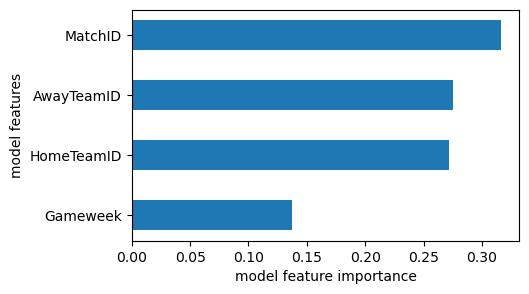

In [488]:
plt.figure(figsize = (5,3))
plt.barh(training.loc[:, ~training.columns.isin(['Result__Away','Result__Draw','Result__Home'])].columns[sorted_indices], model.feature_importances_[sorted_indices], height=0.5)
plt.xlabel("model feature importance")
plt.ylabel("model features")

In [489]:
y_hat_training = model.predict(X_training)

In [490]:
y_hat_training

array([[0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

In [146]:
y_training_df = pd.DataFrame(y_training, columns=['Away','Draw','Home'])

In [147]:
y_training_df['Result'] = y_training_df.idxmax(axis=1)
y_training_df = y_training_df.drop(columns=['Away','Draw','Home'])
y_training_df

,Result
0,Home
1,Home
2,Draw
3,Home
4,Draw
...,...
675,Away
676,Home
677,Away
678,Away


In [148]:
y_hat_training_df = pd.DataFrame(y_hat_training, columns=['Away','Draw','Home'])

In [149]:
y_hat_training_df['Result'] = y_hat_training_df.idxmax(axis=1)
y_hat_training_df = y_hat_training_df.drop(columns=['Away','Draw','Home'])
y_hat_training_df

,Result
0,Home
1,Home
2,Away
3,Home
4,Away
...,...
675,Away
676,Home
677,Away
678,Away


In [150]:
# Construct a confusion matrix for the training set
cm = confusion_matrix(y_training_df, y_hat_training_df)

In [151]:
cm_df = pd.DataFrame(cm, 
                     index = ['Away','Draw','Home'],
                     columns = ['Away','Draw','Home'])

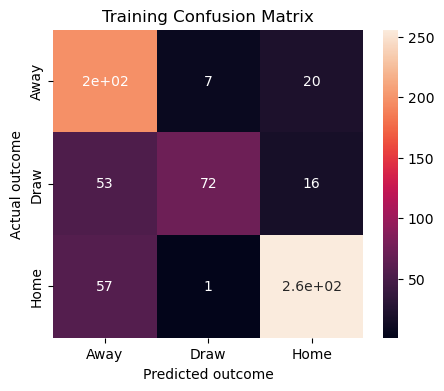

In [152]:
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Training Confusion Matrix')
plt.ylabel('Actual outcome')
plt.xlabel('Predicted outcome')
plt.show()

In [153]:
tp, fp, fn, tn, conf_df, conf_df_2 =calculate_metrics(cm)

<Axes: >

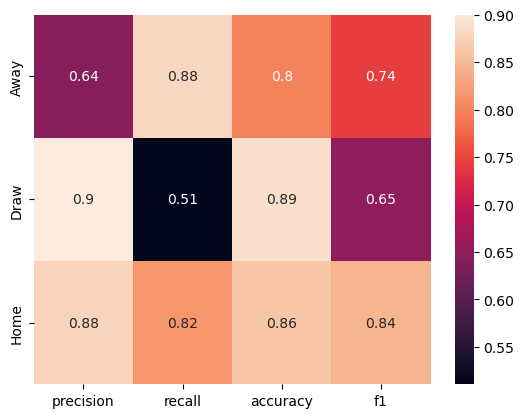

In [154]:
sns.heatmap(conf_df, annot=True)

In [155]:
conf_df_2

,precision,recall,accuracy,f1
model average overall,0.806523,0.735308,0.84902,0.746478


## Validation

In [156]:
y_hat_validation = model.predict(X_validation)

In [157]:
# Get accuracy of the validation set
accuracy_validation = results_class.score(X_validation,y_validation)
accuracy_validation

0.40540540540540543

In [158]:
y_validation_df = pd.DataFrame(y_validation, columns=['Away','Draw','Home'])

In [159]:
y_validation_df['Result'] = y_validation_df.idxmax(axis=1)
y_validation_df = y_validation_df.drop(columns=['Away','Draw','Home'])
y_validation_df

,Result
0,Away
1,Home
2,Away
3,Away
4,Home
...,...
32,Home
33,Home
34,Away
35,Draw


In [160]:
y_hat_validation_df = pd.DataFrame(y_hat_validation, columns=['Away','Draw','Home'])

In [161]:
y_hat_validation_df['Result'] = y_hat_validation_df.idxmax(axis=1)
y_hat_validation_df = y_hat_validation_df.drop(columns=['Away','Draw','Home'])
y_hat_validation_df

,Result
0,Home
1,Away
2,Away
3,Home
4,Home
...,...
32,Home
33,Home
34,Draw
35,Draw


In [162]:
# Construct a confusion matrix for the validation set
cm_validation = confusion_matrix(y_validation_df, y_hat_validation_df)

In [163]:
cm_validation_df = pd.DataFrame(cm_validation, 
                     index = ['Away','Draw','Home'],
                     columns = ['Away','Draw','Home'])

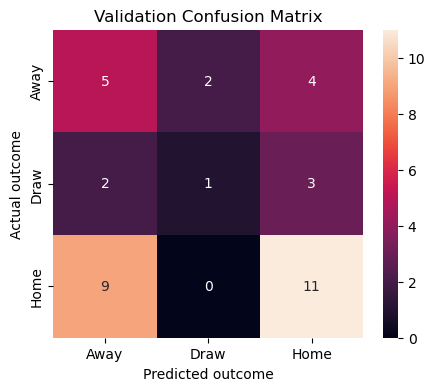

In [164]:
plt.figure(figsize=(5,4))
sns.heatmap(cm_validation_df, annot=True)
plt.title('Validation Confusion Matrix')
plt.ylabel('Actual outcome')
plt.xlabel('Predicted outcome')
plt.show()

In [165]:
tp, fp, fn, tn, conf_df_val, conf_df_val_2 =calculate_metrics(cm_validation)

<Axes: >

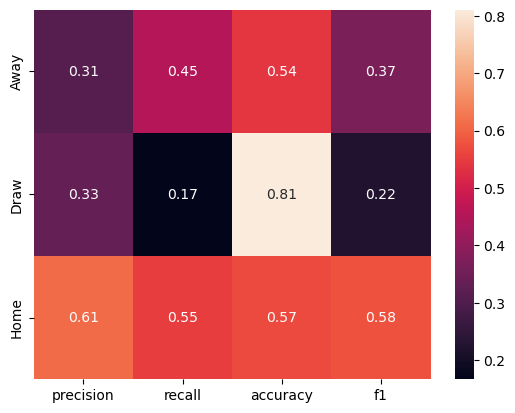

In [166]:
sns.heatmap(conf_df_val, annot=True)

In [167]:
conf_df_val_2

,precision,recall,accuracy,f1
model average overall,0.418981,0.390404,0.63964,0.390513


## Test

In [168]:
y_hat_test = model.predict(X_test)

In [169]:
# Get accuracy of the test set
accuracy_test = results_class.score(X_test,y_test)
accuracy_test

0.23076923076923078

In [170]:
y_test_df = pd.DataFrame(y_test, columns=['Away','Draw','Home'])

In [171]:
y_test_df['Result'] = y_test_df.idxmax(axis=1)
y_test_df = y_test_df.drop(columns=['Away','Draw','Home'])
y_test_df

,Result
0,Away
1,Draw
2,Home
3,Draw
4,Away
...,...
34,Away
35,Home
36,Home
37,Away


In [172]:
y_hat_test_df = pd.DataFrame(y_hat_test, columns=['Away','Draw','Home'])

In [173]:
y_hat_test_df['Result'] = y_hat_test_df.idxmax(axis=1)
y_hat_test_df = y_hat_test_df.drop(columns=['Away','Draw','Home'])
y_hat_test_df

,Result
0,Away
1,Home
2,Away
3,Away
4,Home
...,...
34,Away
35,Away
36,Away
37,Home


In [174]:
# Construct a confusion matrix for the test set
cm_test = confusion_matrix(y_test_df, y_hat_test_df)

In [175]:
cm_test_df = pd.DataFrame(cm_test, 
                     index = ['Away','Draw','Home'],
                     columns = ['Away','Draw','Home'])

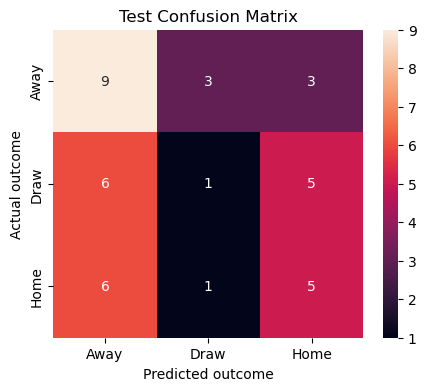

In [176]:
plt.figure(figsize=(5,4))
sns.heatmap(cm_test_df, annot=True)
plt.title('Test Confusion Matrix')
plt.ylabel('Actual outcome')
plt.xlabel('Predicted outcome')
plt.show()

In [177]:
tp, fp, fn, tn, conf_df_test, conf_df_test_2 =calculate_metrics(cm_test)

<Axes: >

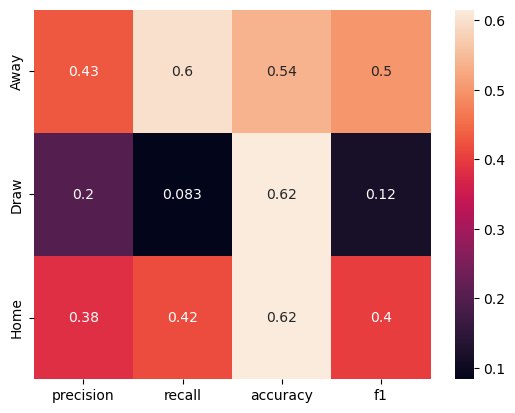

In [178]:
sns.heatmap(conf_df_test, annot=True)

In [179]:
conf_df_test_2

,precision,recall,accuracy,f1
model average overall,0.337729,0.366667,0.589744,0.339216


## Save the model 

In [180]:
import pickle

In [181]:
#softmax_pickle = open("random_forest_result_prediction_(Gameweek_MatchID_HomeTeamID_AwayTeamID_only)_90_5_5_5trees_10max_depth", 'wb')
#pickle.dump(model, softmax_pickle)

## Load the model and make predictions on season 2

In [357]:
#load the random forest model to predict result
model = pickle.load(open("random_forest_result_prediction_(Gameweek_MatchID_HomeTeamID_AwayTeamID_only)_90_5_5_5trees_10max_depth", 'rb'))

In [358]:
final_df_inference = pd.read_csv('season_2_results_(reduced_features).csv')

In [359]:
final_df_inference

,Gameweek,MatchID,HomeTeamID,AwayTeamID,Result__Away,Result__Draw,Result__Home
0,1,757,2,1,1,0,0
1,1,758,28,3,0,0,1
2,1,759,27,4,1,0,0
3,1,760,26,5,1,0,0
4,1,761,25,6,1,0,0
...,...,...,...,...,...,...,...
751,54,1508,10,19,1,0,0
752,54,1509,11,18,0,0,1
753,54,1510,12,17,0,1,0
754,54,1511,13,16,0,0,1


In [360]:
#number of Draw results in the season 2 inference dataframe
print(f"number of Draws in the season 2 results dataframe = {len(final_df_inference[final_df_inference['Result__Draw']==1])}")

number of Draws in the season 2 results dataframe = 139


In [361]:
#number of Away wins in the season 2 inference dataframe
print(f"number of Away wins in the season 2 results dataframe = {len(final_df_inference[final_df_inference['Result__Away']==1])}")

number of Away wins in the season 2 results dataframe = 257


In [362]:
#number of Home wins in the season 2 inference dataframe
print(f"number of Home wins in the season 2 results dataframe = {len(final_df_inference[final_df_inference['Result__Home']==1])}")

number of Home wins in the season 2 results dataframe = 360


In [363]:
# set inference y
y_inference = final_df_inference[['Result__Away','Result__Draw','Result__Home']].to_numpy()
y_inference 

array([[1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       ...,
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0]], dtype=int64)

In [364]:
# set inference x
X_inference = final_df_inference.loc[:, ~final_df_inference.columns.isin(['Result__Away','Result__Draw','Result__Home'])].to_numpy()
len(X_inference[0])

4

In [365]:
y_hat_inference = model.predict(X_inference)

In [366]:
# Get accuracy of the inference set
accuracy_inference = results_class.score(X_inference,y_inference)
accuracy_inference

0.3835978835978836

In [367]:
y_inference_df = pd.DataFrame(y_inference, columns=['Away','Draw','Home'])

In [368]:
y_inference_df['Result_actual'] = y_inference_df.idxmax(axis=1)
y_inference_df = y_inference_df.drop(columns=['Away','Draw','Home'])
y_inference_df

,Result_actual
0,Away
1,Home
2,Away
3,Away
4,Away
...,...
751,Away
752,Home
753,Draw
754,Home


In [369]:
y_hat_inference_df = pd.DataFrame(y_hat_inference, columns=['Away','Draw','Home'])

In [370]:
y_hat_inference_df['Result_predicted'] = y_hat_inference_df.idxmax(axis=1)
y_hat_inference_df = y_hat_inference_df.drop(columns=['Away','Draw','Home'])
y_hat_inference_df

,Result_predicted
0,Home
1,Away
2,Away
3,Away
4,Away
...,...
751,Home
752,Home
753,Home
754,Home


In [371]:
# Construct a confusion matrix for the inference set
cm_inference = confusion_matrix(y_inference_df, y_hat_inference_df)

In [372]:
cm_inference

array([[176,   3,  78],
       [ 77,   1,  61],
       [178,   3, 179]], dtype=int64)

In [373]:
cm_inference_df = pd.DataFrame(cm_inference, 
                     index = ['Away','Draw','Home'],
                     columns = ['Away','Draw','Home'])

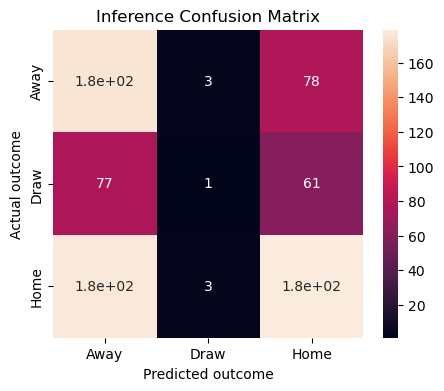

In [374]:
plt.figure(figsize=(5,4))
sns.heatmap(cm_inference_df, annot=True)
plt.title('Inference Confusion Matrix')
plt.ylabel('Actual outcome')
plt.xlabel('Predicted outcome')
plt.show()

In [375]:
tp, fp, fn, tn, conf_df_inference, conf_df_inference_2 =calculate_metrics(cm_inference)

<Axes: >

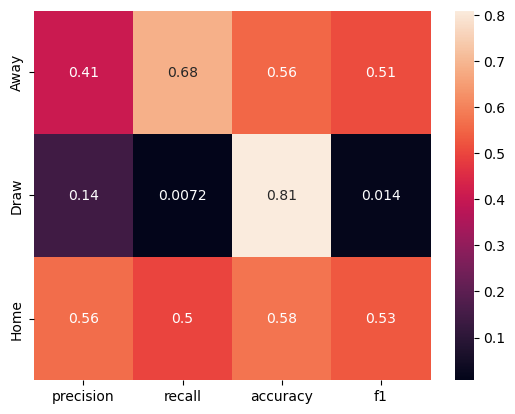

In [376]:
sns.heatmap(conf_df_inference, annot=True)

In [377]:
conf_df_inference_2

,precision,recall,accuracy,f1
model average overall,0.371368,0.396414,0.647266,0.351117


# Season 2 predictions

In [442]:
final_df_inference_1 = final_df_inference.join(y_hat_inference_df)
final_df_inference_2 = final_df_inference_1.join(y_inference_df)
final_df_inference_2

,Gameweek,MatchID,HomeTeamID,AwayTeamID,Result__Away,Result__Draw,Result__Home,Result_predicted,Result_actual
0,1,757,2,1,1,0,0,Home,Away
1,1,758,28,3,0,0,1,Away,Home
2,1,759,27,4,1,0,0,Away,Away
3,1,760,26,5,1,0,0,Away,Away
4,1,761,25,6,1,0,0,Away,Away
...,...,...,...,...,...,...,...,...,...
751,54,1508,10,19,1,0,0,Home,Away
752,54,1509,11,18,0,0,1,Home,Home
753,54,1510,12,17,0,1,0,Home,Draw
754,54,1511,13,16,0,0,1,Home,Home


In [443]:
final_df_inference_2 = final_df_inference_2.drop(columns=['Result__Away','Result__Draw','Result__Home'])
final_df_inference_2

,Gameweek,MatchID,HomeTeamID,AwayTeamID,Result_predicted,Result_actual
0,1,757,2,1,Home,Away
1,1,758,28,3,Away,Home
2,1,759,27,4,Away,Away
3,1,760,26,5,Away,Away
4,1,761,25,6,Away,Away
...,...,...,...,...,...,...
751,54,1508,10,19,Home,Away
752,54,1509,11,18,Home,Home
753,54,1510,12,17,Home,Draw
754,54,1511,13,16,Home,Home


In [444]:
final_df_inference_2['Predicted_Home_points'] = final_df_inference_2.apply(lambda x: 1 if x['Result_predicted'] == 'Draw'
                                        else (3 if x['Result_predicted'] == 'Home'
                                              else 0), axis=1)

final_df_inference_2['Predicted_Away_points'] = final_df_inference_2.apply(lambda x: 1 if x['Result_predicted'] == 'Draw'
                                        else (3 if x['Result_predicted'] == 'Away'
                                              else 0), axis=1)

In [445]:
final_df_inference_2['Actual_Home_points'] = final_df_inference_2.apply(lambda x: 1 if x['Result_actual'] == 'Draw'
                                        else (3 if x['Result_actual'] == 'Home'
                                              else 0), axis=1)

final_df_inference_2['Actual_Away_points'] = final_df_inference_2.apply(lambda x: 1 if x['Result_actual'] == 'Draw'
                                        else (3 if x['Result_actual'] == 'Away'
                                              else 0), axis=1)

In [446]:
final_df_inference_2

,Gameweek,MatchID,HomeTeamID,AwayTeamID,Result_predicted,Result_actual,Predicted_Home_points,Predicted_Away_points,Actual_Home_points,Actual_Away_points
0,1,757,2,1,Home,Away,3,0,0,3
1,1,758,28,3,Away,Home,0,3,3,0
2,1,759,27,4,Away,Away,0,3,0,3
3,1,760,26,5,Away,Away,0,3,0,3
4,1,761,25,6,Away,Away,0,3,0,3
...,...,...,...,...,...,...,...,...,...,...
751,54,1508,10,19,Home,Away,3,0,0,3
752,54,1509,11,18,Home,Home,3,0,3,0
753,54,1510,12,17,Home,Draw,3,0,1,1
754,54,1511,13,16,Home,Home,3,0,3,0


### Extract all the season 2 entries where the model predictions and actual results are in agreement

In [447]:
# extract the results where there is agreement between model and actual season 2 results
final_df_inference_2_agreement = final_df_inference_2[final_df_inference_2['Result_predicted'] == final_df_inference_2['Result_actual']]
final_df_inference_2_agreement

,Gameweek,MatchID,HomeTeamID,AwayTeamID,Result_predicted,Result_actual,Predicted_Home_points,Predicted_Away_points,Actual_Home_points,Actual_Away_points
2,1,759,27,4,Away,Away,0,3,0,3
3,1,760,26,5,Away,Away,0,3,0,3
4,1,761,25,6,Away,Away,0,3,0,3
6,1,763,23,8,Away,Away,0,3,0,3
8,1,765,21,10,Home,Home,3,0,3,0
...,...,...,...,...,...,...,...,...,...,...
746,54,1503,5,24,Home,Home,3,0,3,0
749,54,1506,8,21,Home,Home,3,0,3,0
750,54,1507,9,20,Home,Home,3,0,3,0
752,54,1509,11,18,Home,Home,3,0,3,0


In [469]:
final_df_inference_2_agreement[final_df_inference_2_agreement['Result_predicted']=='Draw']

,Gameweek,MatchID,HomeTeamID,AwayTeamID,Result_predicted,Result_actual,Predicted_Home_points,Predicted_Away_points,Actual_Home_points,Actual_Away_points
141,11,898,9,11,Draw,Draw,1,1,1,1


In [448]:
final_df_inference_2_agreement_melted = pd.melt(final_df_inference_2_agreement, id_vars=[], value_vars=['HomeTeamID','AwayTeamID'], var_name='location', value_name='ID')
final_df_inference_2_agreement_melted

,location,ID
0,HomeTeamID,27
1,HomeTeamID,26
2,HomeTeamID,25
3,HomeTeamID,23
4,HomeTeamID,21
...,...,...
707,AwayTeamID,24
708,AwayTeamID,21
709,AwayTeamID,20
710,AwayTeamID,18


In [449]:
final_df_inference_2_agreement_results = pd.melt(final_df_inference_2_agreement, id_vars=[], value_vars=['Predicted_Home_points','Predicted_Away_points'], var_name='location', value_name='points')
final_df_inference_2_agreement_results

,location,points
0,Predicted_Home_points,0
1,Predicted_Home_points,0
2,Predicted_Home_points,0
3,Predicted_Home_points,0
4,Predicted_Home_points,3
...,...,...
707,Predicted_Away_points,0
708,Predicted_Away_points,0
709,Predicted_Away_points,0
710,Predicted_Away_points,0


In [450]:
final_df_inference_2_agreement_combined = pd.concat([final_df_inference_2_agreement_melted, final_df_inference_2_agreement_results], axis=1)

In [451]:
final_df_inference_2_agreement_combined

,location,ID,location,points
0,HomeTeamID,27,Predicted_Home_points,0
1,HomeTeamID,26,Predicted_Home_points,0
2,HomeTeamID,25,Predicted_Home_points,0
3,HomeTeamID,23,Predicted_Home_points,0
4,HomeTeamID,21,Predicted_Home_points,3
...,...,...,...,...
707,AwayTeamID,24,Predicted_Away_points,0
708,AwayTeamID,21,Predicted_Away_points,0
709,AwayTeamID,20,Predicted_Away_points,0
710,AwayTeamID,18,Predicted_Away_points,0


In [474]:
final_df_inference_2_agreement_combined_grouped = final_df_inference_2_agreement_combined.groupby(['ID','points']).size().unstack(fill_value=0)
final_df_inference_2_agreement_combined_grouped.rename(columns={0:'loss',1:'draw',3:'win'}, inplace=True)
final_df_inference_2_agreement_combined_grouped.reset_index(inplace=True)
final_df_inference_2_agreement_combined_grouped['ID'] = final_df_inference_2_agreement_combined_grouped['ID'].replace(teams_dict)
final_df_inference_2_agreement_combined_grouped

points,ID,loss,draw,win
0,Arlington,10,0,19
1,Anaheim,22,0,5
2,Atlanta,11,0,8
3,Baltimore,2,0,33
4,Boston,3,0,32
...,...,...,...,...
23,St. Louis,16,0,11
24,San Diego,29,0,4
25,San Francisco,17,0,5
26,Seattle,3,0,15


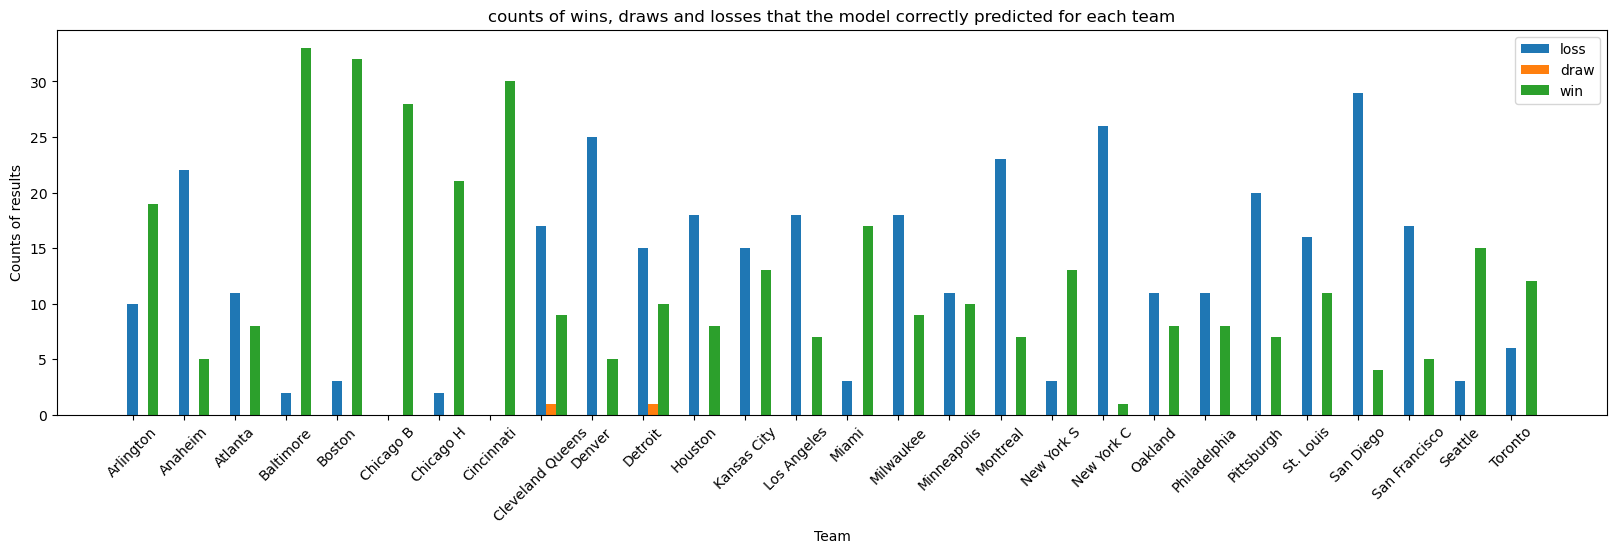

In [477]:
plt.figure(figsize=(20, 5))
bar_width = 0.2
predictors = np.arange(len(final_df_inference_2_agreement_combined_grouped['ID']))
plt.bar(predictors,final_df_inference_2_agreement_combined_grouped['loss'], width=bar_width, label='loss')
plt.bar(predictors+bar_width,final_df_inference_2_agreement_combined_grouped['draw'], width=bar_width, label='draw')
plt.bar(predictors+(2*bar_width),final_df_inference_2_agreement_combined_grouped['win'], width=bar_width, label='win')
plt.xticks(predictors, final_df_inference_2_agreement_combined_grouped['ID'])
plt.tick_params(axis ='x', rotation=45)
plt.ylabel('Counts of results')
plt.xlabel('Team')
plt.title('counts of wins, draws and losses that the model correctly predicted for each team')
plt.legend()
plt.show()

### Team results over season 2

In [384]:
season2_grouped_home_predicted = pd.DataFrame(final_df_inference_2.groupby(['HomeTeamID'])['Predicted_Home_points'].sum()).reset_index()
season2_grouped_away_predicted = pd.DataFrame(final_df_inference_2.groupby(['AwayTeamID'])['Predicted_Away_points'].sum()).reset_index()

season2_grouped_home_actual = pd.DataFrame(final_df_inference_2.groupby(['HomeTeamID'])['Actual_Home_points'].sum()).reset_index()
season2_grouped_away_actual = pd.DataFrame(final_df_inference_2.groupby(['AwayTeamID'])['Actual_Away_points'].sum()).reset_index()

In [385]:
# merge the two grouped predicted dataframes on TeamID
season2_grouped_predicted = pd.merge(season2_grouped_home_predicted, season2_grouped_away_predicted, left_on='HomeTeamID', right_on='AwayTeamID')
season2_grouped_predicted

,HomeTeamID,Predicted_Home_points,AwayTeamID,Predicted_Away_points
0,1,39,1,55
1,2,33,2,32
2,3,39,3,70
3,4,66,4,81
4,5,66,5,79
...,...,...,...,...
23,24,30,24,9
24,25,16,25,15
25,26,7,26,57
26,27,27,27,60


In [386]:
season2_grouped_predicted = season2_grouped_predicted.drop(columns=['HomeTeamID']).rename(columns={'AwayTeamID':'TeamID'})
season2_grouped_predicted['Predicted_total_points'] = season2_grouped_predicted['Predicted_Home_points'] + season2_grouped_predicted['Predicted_Away_points']
season2_grouped_predicted.drop(columns=['Predicted_Home_points','Predicted_Away_points'],inplace=True)
season2_grouped_predicted

,TeamID,Predicted_total_points
0,1,94
1,2,65
2,3,109
3,4,147
4,5,145
...,...,...
23,24,39
24,25,31
25,26,64
26,27,87


In [387]:
# merge the two grouped actual dataframes on TeamID
season2_grouped_actual = pd.merge(season2_grouped_home_actual, season2_grouped_away_actual, left_on='HomeTeamID', right_on='AwayTeamID')
season2_grouped_actual

,HomeTeamID,Actual_Home_points,AwayTeamID,Actual_Away_points
0,1,53,1,37
1,2,27,2,16
2,3,27,3,16
3,4,60,4,54
4,5,60,5,52
...,...,...,...,...
23,24,55,24,36
24,25,27,25,16
25,26,25,26,17
26,27,59,27,51


In [388]:
season2_grouped_actual = season2_grouped_actual.drop(columns=['HomeTeamID']).rename(columns={'AwayTeamID':'TeamID'})
season2_grouped_actual['Actual_total_points'] = season2_grouped_actual['Actual_Home_points'] + season2_grouped_actual['Actual_Away_points']
season2_grouped_actual.drop(columns=['Actual_Home_points','Actual_Away_points'],inplace=True)
season2_grouped_actual

,TeamID,Actual_total_points
0,1,90
1,2,43
2,3,43
3,4,114
4,5,112
...,...,...
23,24,91
24,25,43
25,26,42
26,27,110


In [389]:
season2_grouped_actual_predicted = season2_grouped_actual.merge(season2_grouped_predicted, on='TeamID')
season2_grouped_actual_predicted

,TeamID,Actual_total_points,Predicted_total_points
0,1,90,94
1,2,43,65
2,3,43,109
3,4,114,147
4,5,112,145
...,...,...,...
23,24,91,39
24,25,43,31
25,26,42,64
26,27,110,87


In [390]:
# Sort the team results by predicted total points
season2_grouped_actual_predicted.sort_values('Predicted_total_points',ascending=False)

,TeamID,Actual_total_points,Predicted_total_points
3,4,114,147
4,5,112,145
5,6,107,138
7,8,111,135
6,7,89,132
...,...,...,...
9,10,40,57
21,22,87,51
22,23,64,48
23,24,91,39


In [391]:
# Sort the team results by actual total points
season2_grouped_actual_predicted.sort_values('Actual_total_points',ascending=False)

,TeamID,Actual_total_points,Predicted_total_points
14,15,133,72
18,19,126,63
3,4,114,147
4,5,112,145
7,8,111,135
...,...,...,...
24,25,43,31
2,3,43,109
25,26,42,64
9,10,40,57


In [392]:
# Predicted results table for season 2
season2_grouped_actual_predicted['TeamID'] = season2_grouped_actual_predicted['TeamID'].replace(teams_dict)
season2_grouped_actual_predicted.sort_values('Predicted_total_points', ascending=False)

,TeamID,Actual_total_points,Predicted_total_points
3,Baltimore,114,147
4,Boston,112,145
5,Chicago B,107,138
7,Cincinnati,111,135
6,Chicago H,89,132
...,...,...,...
9,Denver,40,57
21,Philadelphia,87,51
22,Pittsburgh,64,48
23,St. Louis,91,39


In [393]:
#join the season 1 total points results to the table of actual and predicted total points for season 2
season2_grouped_actual_predicted_S1 = season2_grouped_actual_predicted.merge(season1_grouped, on='TeamID')
season2_grouped_actual_predicted_S1.rename(columns={'total_points':'season1_total_points','Actual_total_points':'season2_total_points','Predicted_total_points':'season2_predicted_total_points'},inplace=True)
season2_grouped_actual_predicted_S1

,TeamID,season2_total_points,season2_predicted_total_points,season1_total_points
0,Arlington,90,94,77
1,Anaheim,43,65,32
2,Atlanta,43,109,56
3,Baltimore,114,147,117
4,Boston,112,145,106
...,...,...,...,...
23,St. Louis,91,39,94
24,San Diego,43,31,34
25,San Francisco,42,64,37
26,Seattle,110,87,105


In [394]:
season2_grouped_actual_predicted_S1.sort_values('season2_predicted_total_points', ascending=False)

,TeamID,season2_total_points,season2_predicted_total_points,season1_total_points
3,Baltimore,114,147,117
4,Boston,112,145,106
5,Chicago B,107,138,105
7,Cincinnati,111,135,125
6,Chicago H,89,132,95
...,...,...,...,...
9,Denver,40,57,35
21,Philadelphia,87,51,82
22,Pittsburgh,64,48,80
23,St. Louis,91,39,94


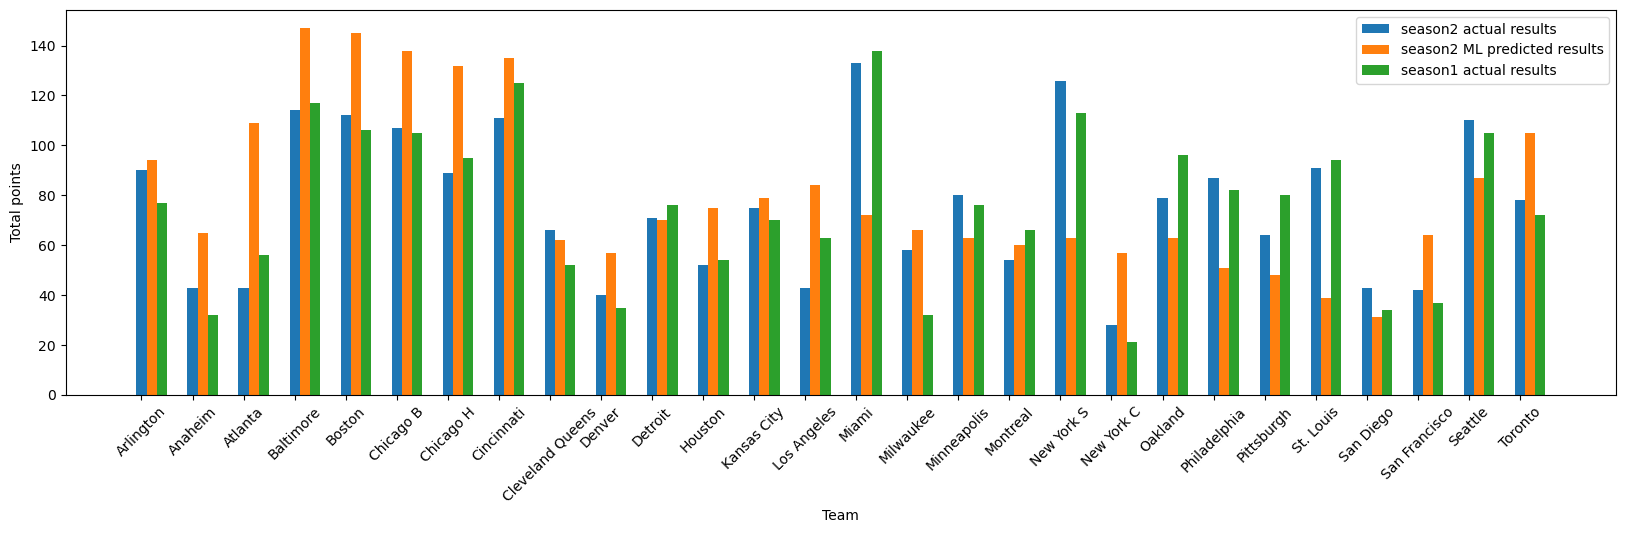

In [395]:
plt.figure(figsize=(20, 5))
bar_width = 0.2
predictors = np.arange(len(season2_grouped_actual_predicted_S1['TeamID']))
plt.bar(predictors,season2_grouped_actual_predicted_S1['season2_total_points'], width=bar_width, label='season2 actual results')
plt.bar(predictors+bar_width,season2_grouped_actual_predicted_S1['season2_predicted_total_points'], width=bar_width, label='season2 ML predicted results')
plt.bar(predictors+(2*bar_width),season2_grouped_actual_predicted_S1['season1_total_points'], width=bar_width, label='season1 actual results')
plt.xticks(predictors, season2_grouped_actual_predicted_S1['TeamID'])
plt.tick_params(axis ='x', rotation=45)
plt.ylabel('Total points')
plt.xlabel('Team')
plt.legend()
plt.show()

### Get the teams where their total scores were very close within season's 1 and 2

In [399]:
# Get the teams where the season 2 final points are within 3 victories (9 points) difference to the equivalent season 1 final points
season2_grouped_actual_S1 = season2_grouped_actual_predicted_S1[abs(season2_grouped_actual_predicted_S1['season1_total_points']-season2_grouped_actual_predicted_S1['season2_total_points']) < 9][['TeamID','season2_total_points','season1_total_points']]
season2_grouped_actual_S1

,TeamID,season2_total_points,season1_total_points
3,Baltimore,114,117
4,Boston,112,106
5,Chicago B,107,105
6,Chicago H,89,95
9,Denver,40,35
...,...,...,...
21,Philadelphia,87,82
23,St. Louis,91,94
25,San Francisco,42,37
26,Seattle,110,105


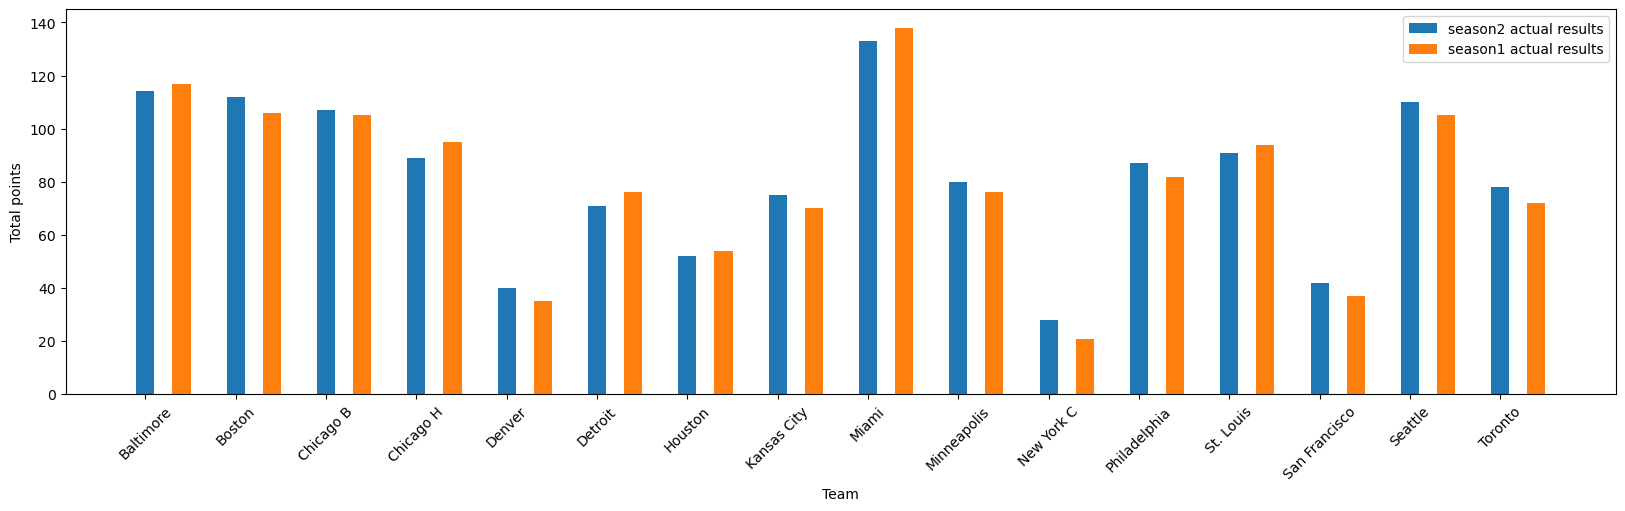

In [401]:
plt.figure(figsize=(20, 5))
bar_width = 0.2
predictors = np.arange(len(season2_grouped_actual_S1['TeamID']))
plt.bar(predictors,season2_grouped_actual_S1['season2_total_points'], width=bar_width, label='season2 actual results')
plt.bar(predictors+(2*bar_width),season2_grouped_actual_S1['season1_total_points'], width=bar_width, label='season1 actual results')
plt.xticks(predictors, season2_grouped_actual_S1['TeamID'])
plt.tick_params(axis ='x', rotation=45)
plt.ylabel('Total points')
plt.xlabel('Team')
plt.legend()
plt.show()

### Get the teams where the model was very close in predicting the total points for season 2

In [397]:
# Get the teams where there's model agreement to the actual season 2 final points within 3 victories (9 points) difference
season2_grouped_actual_predicted_S1[abs(season2_grouped_actual_predicted_S1['season2_predicted_total_points']-season2_grouped_actual_predicted_S1['season2_total_points']) < 9][['TeamID','season2_total_points','season2_predicted_total_points']]

,TeamID,season2_total_points,season2_predicted_total_points
0,Arlington,90,94
8,Cleveland Queens,66,62
10,Detroit,71,70
12,Kansas City,75,79
15,Milwaukee,58,66
17,Montreal,54,60


### Get the teams where their total scores were very close within season's 1 and 2 and model prediction was close for season 2

In [402]:
# Get the teams where there's model agreement to the actual season 2 final points within 3 victories (9 points) difference and also where the season 2 final points are within 3 victories (9 points) difference to the equivalent season 1 final points
season2_grouped_actual_predicted_S1_matched = season2_grouped_actual_predicted_S1[(abs(season2_grouped_actual_predicted_S1['season2_predicted_total_points']-season2_grouped_actual_predicted_S1['season2_total_points']) < 9) & (abs(season2_grouped_actual_predicted_S1['season1_total_points']-season2_grouped_actual_predicted_S1['season2_total_points']) < 9)]
season2_grouped_actual_predicted_S1_matched

,TeamID,season2_total_points,season2_predicted_total_points,season1_total_points
10,Detroit,71,70,76
12,Kansas City,75,79,70


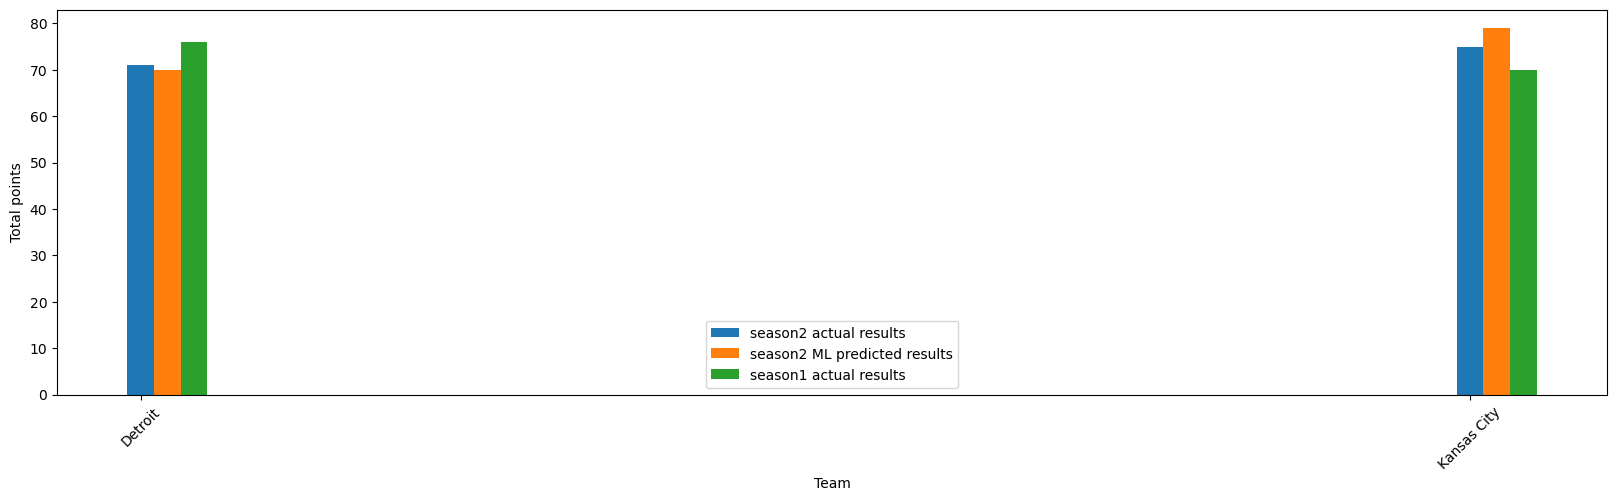

In [404]:
plt.figure(figsize=(20, 5))
bar_width = 0.02
predictors = np.arange(len(season2_grouped_actual_predicted_S1_matched['TeamID']))
plt.bar(predictors,season2_grouped_actual_predicted_S1_matched['season2_total_points'], width=bar_width, label='season2 actual results')
plt.bar(predictors+bar_width,season2_grouped_actual_predicted_S1_matched['season2_predicted_total_points'], width=bar_width, label='season2 ML predicted results')
plt.bar(predictors+(2*bar_width),season2_grouped_actual_predicted_S1_matched['season1_total_points'], width=bar_width, label='season1 actual results')
plt.xticks(predictors, season2_grouped_actual_predicted_S1_matched['TeamID'])
plt.tick_params(axis ='x', rotation=45)
plt.ylabel('Total points')
plt.xlabel('Team')
plt.legend()
plt.show()

- ### Safest option for placing bets are Detroit and Kansas